In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Load your data (assume already loaded as df)

#neuroimaging data 
df = pd.read_csv('patient_level_comprehensive_features_fixed.csv')
print(df.shape)

#shell data is stored in boundary_shell_, deleting shell_ and all clinical data 

df = df.drop(columns=['who_grade', 'age_at_mri', 'sex', 'overall_survival_days', 'mgmt_status', 
                      'mgmt_index', '1p19q', 'idh_status', 'eor',
                      'shell_0_fa_mean', 'shell_0_fa_std', 'shell_0_fa_median', 'shell_0_voxel_count',
                      'shell_1_fa_mean', 'shell_1_fa_std','shell_1_fa_median','shell_1_voxel_count', 
                      'shell_2_fa_mean','shell_2_fa_std','shell_2_fa_median','shell_2_voxel_count',
                      'shell_3_fa_mean','shell_3_fa_std','shell_3_fa_median','shell_3_voxel_count', 
                      'shell_0_gradient_mean', 'shell_0_gradient_std','shell_1_gradient_mean','shell_1_gradient_std',
                      'shell_2_gradient_mean','shell_2_gradient_std','shell_3_gradient_mean','shell_3_gradient_std'])


df.rename(columns={'patient_id': 'ID'}, inplace=True)

#cleaned clinical data upload


df_clinical = pd.read_csv('PDGM/UCSF-PDGM-metadata_v5_cleaned.csv')
#clinical analysis will include sex, MGMT status, IDH status, 1p/19q
 
print(df_clinical.columns)
#dropping other columns
df_clinical = df_clinical.drop(columns=[
       'Final pathologic diagnosis (WHO 2021)', 'MGMT index',
       '1-dead 0-alive', 'OS', 'EOR',
       'Biopsy prior to imaging', 'BraTS21 ID', 'BraTS21 Segmentation Cohort',
       'BraTS21 MGMT Cohort'])

print('updated clinical column list', df_clinical.columns)


                               

    



(500, 91)
Index(['ID', 'Sex', 'Age at MRI', 'WHO CNS Grade',
       'Final pathologic diagnosis (WHO 2021)', 'MGMT status', 'MGMT index',
       '1p/19q', 'IDH', '1-dead 0-alive', 'OS', 'EOR',
       'Biopsy prior to imaging', 'BraTS21 ID', 'BraTS21 Segmentation Cohort',
       'BraTS21 MGMT Cohort'],
      dtype='object')
updated clinical column list Index(['ID', 'Sex', 'Age at MRI', 'WHO CNS Grade', 'MGMT status', '1p/19q',
       'IDH'],
      dtype='object')


In [2]:
#merge dfs by ID and classify grade 2 and 3 as the same

df_merged = pd.merge(df, df_clinical, on ='ID', how='inner')


df_merged['WHO CNS Grade'] = df_merged['WHO CNS Grade'].replace(3, 2)
print('Merged df shape is ', df_merged.shape)

column_grade = ['WHO CNS Grade']

for column in column_grade:
    unique_values = df_merged[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Merged df shape is  (500, 64)
Unique values in column 'WHO CNS Grade': [4 2]


In [13]:
#data pre-prcessing: need to convert categorical data to numbers using one-hot numeric arrays
columns_by_index = ['Sex', 'MGMT status', '1p/19q','IDH']

for column in columns_by_index:
    unique_values = df_merged[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

#all categorical data being encoded, unknowns included
df_encoded = pd.get_dummies(df_merged, columns=['Sex', 'MGMT status', '1p/19q','IDH'], drop_first=True)

print("\nOne-Hot Encoded DataFrame (Pandas):")
print(df_encoded)
    


#testing data w/out clinical features 
#indices_to_drop = ['Sex', 'MGMT status', '1p/19q','IDH']
#columns_by_index = df.columns[indices_to_drop].tolist()
#df_dropped = df.drop(columns=columns_by_index)


#df = df.drop(columns=[indices_to_drop])
#print(df_dropped)



Unique values in column 'Sex': ['M' 'F']
Unique values in column 'MGMT status': ['negative' 'unknown' 'positive']
Unique values in column '1p/19q': ['unknown' 'intact' 'co-deletion']
Unique values in column 'IDH': ['wildtype' 'mutated']

One-Hot Encoded DataFrame (Pandas):
                ID   fa_mean    fa_std  fa_min    fa_max  fa_median     fa_p5  \
0    UCSF-PDGM-004  0.253438  0.163584     0.0  1.192218   0.212847  0.059179   
1    UCSF-PDGM-005  0.225728  0.150805     0.0  1.173550   0.180397  0.058431   
2    UCSF-PDGM-007  0.245633  0.146553     0.0  1.214064   0.209004  0.073694   
3    UCSF-PDGM-008  0.270115  0.155586     0.0  1.138740   0.228412  0.086311   
4    UCSF-PDGM-009  0.200340  0.136351     0.0  1.124572   0.158248  0.054843   
..             ...       ...       ...     ...       ...        ...       ...   
495  UCSF-PDGM-536  0.256128  0.145090     0.0  1.187934   0.221200  0.087824   
496  UCSF-PDGM-537  0.253504  0.164926     0.0  1.188299   0.207506  0.065204 

In [4]:
#replacing NAs and unknowns with 0s, change before submitting


missing_counts = df_encoded.isna().sum()
pd.options.display.max_rows = 400
#print(missing_counts,'NAs')
print(sum(missing_counts), 'NA total') #note that survival days col has missing value-what to do with that? 


df_filled = df_encoded.fillna(0)
print('Number of NAs is now :', sum(df_filled.isna().sum()>0)) #delete the one person 
#delete survival data

#confirm no NAs 
#print(sum(df_filled.isna().sum()>0))







0 NA total
Number of NAs is now : 0


In [5]:
#Check unknowns in dataset


# Flatten the DataFrame into a single Series
all_values = df_filled.stack()
count_unknowns = (all_values == 'unknown').sum()
print(f"Count of value unknown in the entire DataFrame: {count_unknowns}")




#print(df_clean)


Count of value unknown in the entire DataFrame: 0


In [14]:
# Split into train/test with stratification to maintain class distribution


train = pd.read_csv('PDGM/train_metadata.csv')['ID']
print(train.shape, 'in train')



#df_train= train.merge(df_filled,how='inner', )
#print(train)
df_train = df_filled[df_filled['ID'].isin(train.tolist())]
#print(df_train)
print(df_train.shape)






test=  pd.read_csv('PDGM/test_metadata.csv')['ID']
print(test.shape, 'in test')
df_test = df_filled[df_filled['ID'].isin(test.tolist())]




print(df_test.shape)





(400,) in train
(399, 66)
(101,) in test
(101, 66)


In [2]:
import pandas as pd
import numpy as np

def create_updated_metadata_with_imaging():
    """
    Create updated train_metadata.csv and test_metadata.csv files 
    with imaging features merged in
    """
    print("="*60)
    print("CREATING UPDATED METADATA WITH IMAGING FEATURES")
    print("="*60)
    
    # Load neuroimaging data 
    print("\n1. Loading neuroimaging features...")
    df = pd.read_csv('patient_level_comprehensive_features_fixed.csv')
    print(f"   Original imaging data shape: {df.shape}")
    
    # Remove clinical data but KEEP shell data (shell data is imaging-derived)
    print("\n2. Filtering clinical features (keeping shell features)...")
    clinical_cols = ['who_grade', 'age_at_mri', 'sex', 'overall_survival_days', 
                    'mgmt_status', 'mgmt_index', '1p19q', 'idh_status', 'eor']
    
    # Only drop columns that actually exist in the dataframe
    cols_to_drop = [col for col in clinical_cols if col in df.columns]
    
    df_imaging = df.drop(columns=cols_to_drop)
    df_imaging = df_imaging.rename(columns={'patient_id': 'ID'})
    
    print(f"   Filtered imaging data shape: {df_imaging.shape}")
    print(f"   Removed {len(cols_to_drop)} clinical columns (kept shell features)")
    
    # Load cleaned clinical data
    print("\n3. Loading clinical metadata...")
    df_clinical = pd.read_csv('PDGM/UCSF-PDGM-metadata_v5_cleaned.csv')
    print(f"   Original clinical data shape: {df_clinical.shape}")
    
    # Keep only essential clinical columns
    clinical_keep_cols = ['ID', 'WHO CNS Grade', 'Age at MRI', 'Sex', 
                         'MGMT status', '1p/19q', 'IDH']
    
    # Only keep columns that exist
    clinical_keep_cols = [col for col in clinical_keep_cols if col in df_clinical.columns]
    df_clinical_filtered = df_clinical[clinical_keep_cols].copy()
    
    print(f"   Filtered clinical data shape: {df_clinical_filtered.shape}")
    print(f"   Kept columns: {clinical_keep_cols}")
    
    # Merge imaging and clinical data
    print("\n4. Merging imaging and clinical data...")
    df_merged = pd.merge(df_imaging, df_clinical_filtered, on='ID', how='inner')
    
    # Combine grade 2 and 3 as same class
    if 'WHO CNS Grade' in df_merged.columns:
        df_merged['WHO CNS Grade'] = df_merged['WHO CNS Grade'].replace(3, 2)
        print(f"   Grade distribution: {df_merged['WHO CNS Grade'].value_counts().to_dict()}")
    
    print(f"   Merged data shape: {df_merged.shape}")
    
    # Handle categorical variables with one-hot encoding
    print("\n5. Processing categorical variables...")
    categorical_cols = ['Sex', 'MGMT status', '1p/19q', 'IDH']
    # Only encode columns that exist
    categorical_cols = [col for col in categorical_cols if col in df_merged.columns]
    
    if categorical_cols:
        print(f"   Encoding categorical columns: {categorical_cols}")
        
        # Show unique values before encoding
        for col in categorical_cols:
            unique_vals = df_merged[col].unique()
            print(f"   '{col}' unique values: {unique_vals}")
        
        # One-hot encode
        df_encoded = pd.get_dummies(df_merged, columns=categorical_cols, 
                                   drop_first=True, dummy_na=True)
    else:
        df_encoded = df_merged.copy()
    
    print(f"   Data shape after encoding: {df_encoded.shape}")
    
    # Handle missing values
    print("\n6. Handling missing values...")
    missing_before = df_encoded.isna().sum().sum()
    print(f"   Missing values before filling: {missing_before}")
    
    # Fill missing values with appropriate strategies
    for col in df_encoded.columns:
        if col == 'ID':
            continue
        elif df_encoded[col].dtype in ['int64', 'float64']:
            # Fill numeric columns with median
            df_encoded[col] = df_encoded[col].fillna(df_encoded[col].median())
        else:
            # Fill categorical columns with 0 (for dummy variables)
            df_encoded[col] = df_encoded[col].fillna(0)
    
    missing_after = df_encoded.isna().sum().sum()
    print(f"   Missing values after filling: {missing_after}")
    
    # Load existing train/test splits
    print("\n7. Loading existing train/test splits...")
    train_ids = pd.read_csv('PDGM/train_metadata.csv')['ID']
    test_ids = pd.read_csv('PDGM/test_metadata.csv')['ID']
    
    print(f"   Original train size: {len(train_ids)}")
    print(f"   Original test size: {len(test_ids)}")
    
    # Filter merged data by train/test splits
    df_train_updated = df_encoded[df_encoded['ID'].isin(train_ids)].copy()
    df_test_updated = df_encoded[df_encoded['ID'].isin(test_ids)].copy()
    
    print(f"   Updated train size: {len(df_train_updated)}")
    print(f"   Updated test size: {len(df_test_updated)}")
    
    # Check for any missing IDs
    missing_train = set(train_ids) - set(df_train_updated['ID'])
    missing_test = set(test_ids) - set(df_test_updated['ID'])
    
    if missing_train:
        print(f"   WARNING: {len(missing_train)} train IDs not found in merged data")
    if missing_test:
        print(f"   WARNING: {len(missing_test)} test IDs not found in merged data")
    
    # Verify grade distributions are maintained
    print("\n8. Verifying class distributions...")
    if 'WHO CNS Grade' in df_train_updated.columns:
        train_dist = df_train_updated['WHO CNS Grade'].value_counts(normalize=True)
        test_dist = df_test_updated['WHO CNS Grade'].value_counts(normalize=True)
        
        print("   Train grade distribution:")
        for grade, prop in train_dist.items():
            print(f"     Grade {grade}: {prop:.1%}")
        
        print("   Test grade distribution:")
        for grade, prop in test_dist.items():
            print(f"     Grade {grade}: {prop:.1%}")
    
    # Save updated files
    print("\n9. Saving updated metadata files...")
    
    # Save complete datasets with all features
    df_train_updated.to_csv('PDGM/train_metadata_with_imaging.csv', index=False)
    df_test_updated.to_csv('PDGM/test_metadata_with_imaging.csv', index=False)
    
    print(f"   ✓ Saved 'train_metadata_with_imaging.csv' ({df_train_updated.shape})")
    print(f"   ✓ Saved 'test_metadata_with_imaging.csv' ({df_test_updated.shape})")
    
    # Also create separate imaging-only feature files for the imaging classifier
    imaging_feature_cols = [col for col in df_encoded.columns 
                           if col not in ['ID', 'WHO CNS Grade', 'Age at MRI'] + 
                           [c for c in df_encoded.columns if any(x in c for x in ['Sex_', 'MGMT_', 'IDH_', '1p/19q_'])]]
    
    # Create imaging-only datasets
    train_imaging = df_train_updated[['ID'] + imaging_feature_cols].copy()
    test_imaging = df_test_updated[['ID'] + imaging_feature_cols].copy()
    
    train_imaging.to_csv('PDGM/train_imaging_features.csv', index=False)
    test_imaging.to_csv('PDGM/test_imaging_features.csv', index=False)
    
    print(f"   ✓ Saved 'train_imaging_features.csv' ({train_imaging.shape})")
    print(f"   ✓ Saved 'test_imaging_features.csv' ({test_imaging.shape})")
    
    # Create minimal metadata files (just ID and grade for compatibility)
    train_minimal = df_train_updated[['ID', 'WHO CNS Grade']].copy()
    test_minimal = df_test_updated[['ID', 'WHO CNS Grade']].copy()
    
    train_minimal.to_csv('PDGM/train_metadata_minimal.csv', index=False)
    test_minimal.to_csv('PDGM/test_metadata_minimal.csv', index=False)
    
    print(f"   ✓ Saved 'train_metadata_minimal.csv' ({train_minimal.shape})")
    print(f"   ✓ Saved 'test_metadata_minimal.csv' ({test_minimal.shape})")
    
    # Summary report
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"Created files:")
    print(f"  1. train_metadata_with_imaging.csv - Complete train data with all features")
    print(f"  2. test_metadata_with_imaging.csv  - Complete test data with all features")
    print(f"  3. train_imaging_features.csv      - Imaging features only (train)")
    print(f"  4. test_imaging_features.csv       - Imaging features only (test)")
    print(f"  5. train_metadata_minimal.csv      - Just ID and grade (train)")
    print(f"  6. test_metadata_minimal.csv       - Just ID and grade (test)")
    print(f"\nFeature breakdown:")
    print(f"  Total features: {len(df_encoded.columns) - 1}")  # -1 for ID
    print(f"  Imaging features: {len(imaging_feature_cols)}")
    print(f"  Clinical features: {len(df_encoded.columns) - len(imaging_feature_cols) - 2}")  # -2 for ID and grade
    
    return df_train_updated, df_test_updated

# Example usage for the imaging-only classifier
def update_imaging_classifier_paths():
    """
    Update the imaging classifier to use the new file structure
    """
    print("\nTo use with the imaging-only classifier, update the paths:")
    print("\nmodel, metrics, importance = train_imaging_classifier(")
    print("    train_metadata_path='PDGM/train_metadata_minimal.csv',")
    print("    test_metadata_path='PDGM/test_metadata_minimal.csv',")
    print("    train_imaging_path='PDGM/train_imaging_features.csv',")
    print("    test_imaging_path='PDGM/test_imaging_features.csv',")
    print("    save_prefix='imaging_only'")
    print(")")

if __name__ == "__main__":
    # Run the data preparation
    train_data, test_data = create_updated_metadata_with_imaging()
    
    # Show how to use with imaging classifier
    update_imaging_classifier_paths()

CREATING UPDATED METADATA WITH IMAGING FEATURES

1. Loading neuroimaging features...
   Original imaging data shape: (500, 91)

2. Filtering clinical features (keeping shell features)...
   Filtered imaging data shape: (500, 82)
   Removed 9 clinical columns (kept shell features)

3. Loading clinical metadata...
   Original clinical data shape: (501, 16)
   Filtered clinical data shape: (501, 7)
   Kept columns: ['ID', 'WHO CNS Grade', 'Age at MRI', 'Sex', 'MGMT status', '1p/19q', 'IDH']

4. Merging imaging and clinical data...
   Grade distribution: {4: 401, 2: 99}
   Merged data shape: (500, 88)

5. Processing categorical variables...
   Encoding categorical columns: ['Sex', 'MGMT status', '1p/19q', 'IDH']
   'Sex' unique values: ['M' 'F']
   'MGMT status' unique values: ['negative' 'unknown' 'positive']
   '1p/19q' unique values: ['unknown' 'intact' 'co-deletion']
   'IDH' unique values: ['wildtype' 'mutated']
   Data shape after encoding: (500, 94)

6. Handling missing values...
  

IMAGING-ONLY RANDOM FOREST PIPELINE

1. Loading updated metadata with imaging features...
   Train data shape: (399, 94)
   Test data shape: (101, 94)

2. Filtering imaging features...
   Imaging features before filtering: 81
   Redundant features removed: 16
   Final imaging features: 65
   Actually removed: ['fa_min', 'fa_max', 'fa_median', 'fa_mode', 'fa_p5', 'fa_p95', 'fa_p10', 'fa_p90', 'fa_std', 'gradient_std', 'hemispheric_asymmetry_std', 'gradient_median', 'superior_fa_mean', 'inferior_fa_mean', 'left_hemisphere_fa_mean', 'right_hemisphere_fa_mean']
   Total columns: 94
   Excluded columns: 13
   Imaging features: 65

FEATURE CATEGORIZATION

ESSENTIAL COLUMNS (excluded):
   ID
   WHO CNS Grade

CLINICAL/MOLECULAR FEATURES (excluded):
   1p/19q_intact
   1p/19q_nan
   1p/19q_unknown
   Age at MRI
   IDH_nan
   IDH_wildtype
   MGMT status_nan
   MGMT status_positive
   MGMT status_unknown
   Sex_M
   Sex_nan

IMAGING FEATURES (included - showing first 20):
   boundary_shell_0_fa_

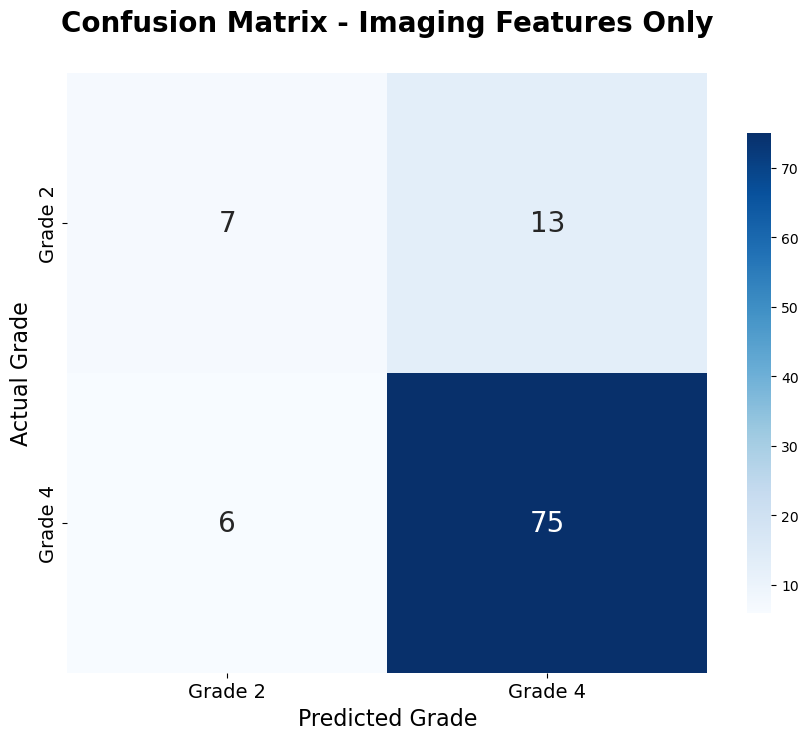

   ✓ Confusion matrix saved as 'PDGM/confusion_matrix_imaging.png'


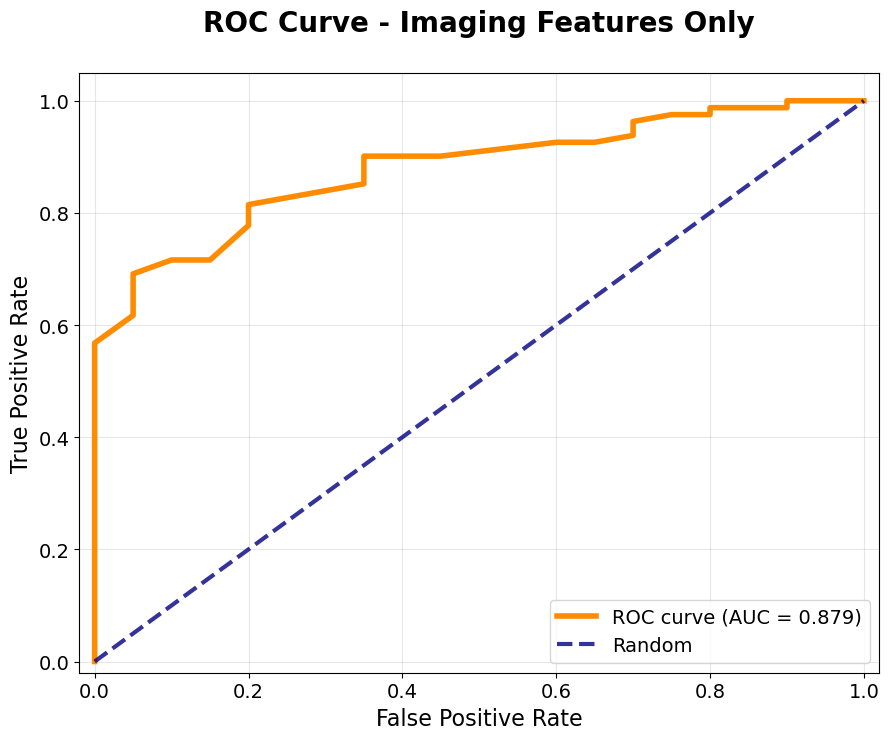

   ✓ ROC curve saved as 'PDGM/roc_curve_imaging.png'


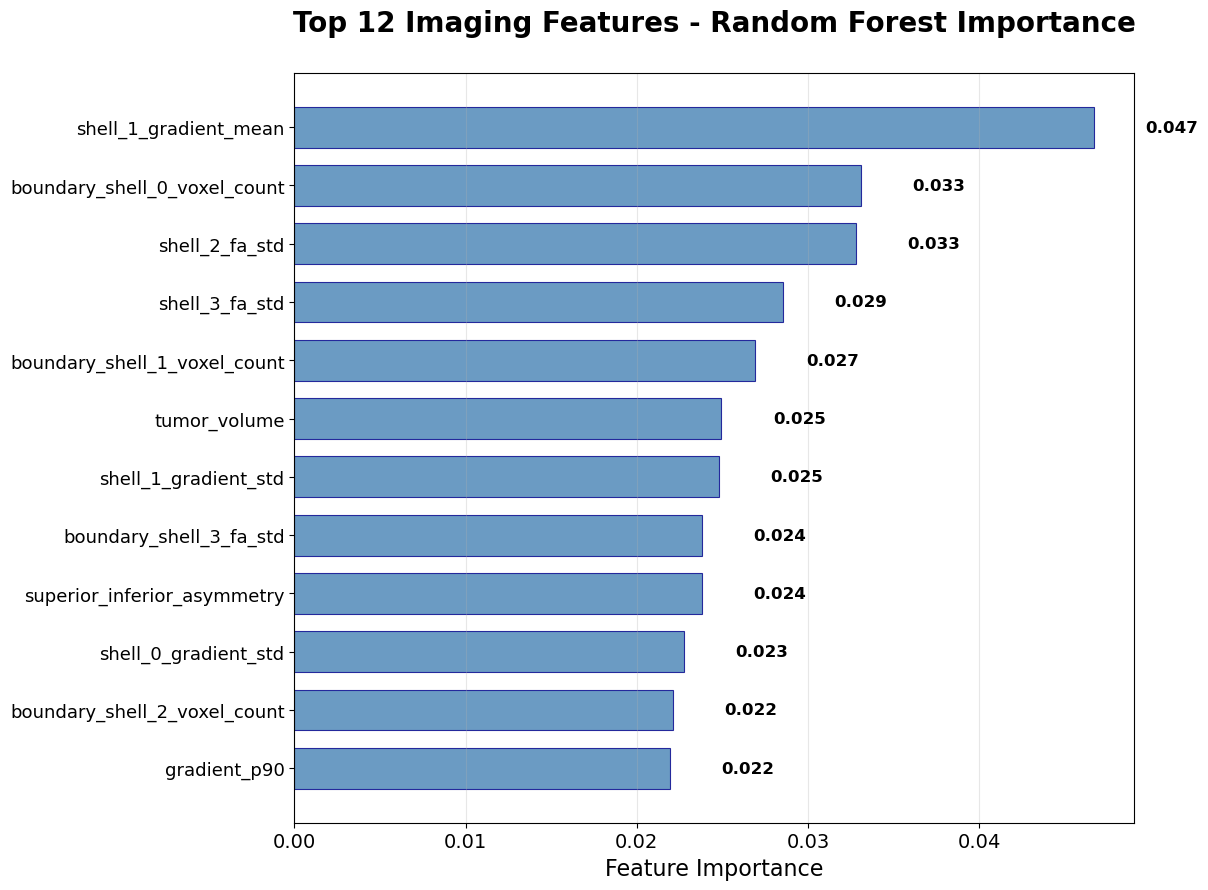

   ✓ Feature importance plot saved as 'PDGM/feature_importance_imaging.png'

   ✓ All individual plots created and saved for PowerPoint use

FEATURE IMPORTANCE ANALYSIS

ALL IMAGING FEATURES RANKED BY IMPORTANCE:
Rank Feature                                              Importance  Cumulative%
--------------------------------------------------------------------------------
   1. shell_1_gradient_mean                           :   0.046720 (   4.7%)
   2. boundary_shell_0_voxel_count                    :   0.033080 (   8.0%)
   3. shell_2_fa_std                                  :   0.032777 (  11.3%)
   4. shell_3_fa_std                                  :   0.028529 (  14.1%)
   5. boundary_shell_1_voxel_count                    :   0.026907 (  16.8%)
   6. tumor_volume                                    :   0.024946 (  19.3%)
   7. shell_1_gradient_std                            :   0.024793 (  21.8%)
   8. boundary_shell_3_fa_std                         :   0.023817 (  24.2%)
   9. su

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           balanced_accuracy_score, roc_curve, auc)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

def run_imaging_only_pipeline():
    """
    Run Random Forest pipeline using only imaging features from the updated metadata files
    """
    print("="*60)
    print("IMAGING-ONLY RANDOM FOREST PIPELINE")
    print("="*60)
    
    # Load the updated metadata files with imaging features
    print("\n1. Loading updated metadata with imaging features...")
    df_train = pd.read_csv('PDGM/train_metadata_with_imaging.csv')
    df_test = pd.read_csv('PDGM/test_metadata_with_imaging.csv')
    
    print(f"   Train data shape: {df_train.shape}")
    print(f"   Test data shape: {df_test.shape}")
    
    # Identify and filter only imaging features
    print("\n2. Filtering imaging features...")
    
    # Columns to exclude (non-imaging features)
    exclude_cols = ['ID', 'WHO CNS Grade']
    
    # Clinical/molecular feature patterns to exclude - MGMT is molecular/clinical!
    clinical_patterns = ['Sex_', 'MGMT', 'mgmt', 'IDH_', 'idh', '1p/19q_', '1p19q', 'Age', 'age']
    
    # Also check for any original clinical columns that might still be present
    clinical_exact_matches = ['MGMT status', 'MGMT index', 'mgmt_status', 'mgmt_index', 
                             'Sex', 'sex', 'IDH', 'idh', 'IDH_status', 'idh_status',
                             '1p/19q', '1p19q', 'Age at MRI', 'age_at_mri', 
                             'EOR', 'eor', 'overall_survival_days']
    
    # Get all column names
    all_cols = df_train.columns.tolist()
    
    # Find clinical columns to exclude (pattern-based)
    clinical_cols = []
    for col in all_cols:
        if any(pattern in col for pattern in clinical_patterns):
            clinical_cols.append(col)
    
    # Find clinical columns to exclude (exact matches)
    clinical_exact = [col for col in all_cols if col in clinical_exact_matches]
    
    # Combine all exclusions
    all_clinical = list(set(clinical_cols + clinical_exact))
    final_exclude = exclude_cols + all_clinical
    
    # Keep only imaging features
    imaging_cols_all = [col for col in all_cols if col not in final_exclude]
    
    # Drop redundant/noisy imaging features for cleaner analysis
    redundant_features = [
        'fa_min', 'fa_max', 'fa_median', 'fa_mode',  # redundant with other stats
        'fa_p5', 'fa_p95', 'fa_p10', 'fa_p90',      # extreme percentiles, noisy
        'fa_std', 'gradient_std', 'hemispheric_asymmetry_std',  # all std features - noisy
        'gradient_median',                           # redundant with gradient_mean
        'superior_fa_mean', 'inferior_fa_mean',      # keep asymmetry ratio instead
        'left_hemisphere_fa_mean', 'right_hemisphere_fa_mean'  # keep asymmetry instead
    ]
    
    # Filter out redundant features
    imaging_cols = [col for col in imaging_cols_all if col not in redundant_features]
    
    print(f"   Imaging features before filtering: {len(imaging_cols_all)}")
    print(f"   Redundant features removed: {len(redundant_features)}")
    print(f"   Final imaging features: {len(imaging_cols)}")
    
    # Show which redundant features were actually present and removed
    actually_removed = [col for col in redundant_features if col in imaging_cols_all]
    if actually_removed:
        print(f"   Actually removed: {actually_removed}")
    else:
        print(f"   Note: None of the redundant features were present in dataset")
    
    print(f"   Total columns: {len(all_cols)}")
    print(f"   Excluded columns: {len(final_exclude)}")
    print(f"   Imaging features: {len(imaging_cols)}")
    
    # Print detailed breakdown of features
    print(f"\n" + "="*50)
    print("FEATURE CATEGORIZATION")
    print("="*50)
    
    print(f"\nESSENTIAL COLUMNS (excluded):")
    for col in exclude_cols:
        if col in all_cols:
            print(f"   {col}")
    
    print(f"\nCLINICAL/MOLECULAR FEATURES (excluded):")
    clinical_sorted = sorted(all_clinical)
    for col in clinical_sorted:
        print(f"   {col}")
    
    print(f"\nIMAGING FEATURES (included - showing first 20):")
    imaging_sorted = sorted(imaging_cols)
    for i, col in enumerate(imaging_sorted[:20]):
        print(f"   {col}")
    if len(imaging_cols) > 20:
        print(f"   ... and {len(imaging_cols) - 20} more imaging features")
    
    print(f"\nFEATURE SUMMARY:")
    print(f"   Clinical/molecular features excluded: {len(all_clinical)}")
    print(f"   Imaging features included: {len(imaging_cols)}")
    print(f"   Essential columns excluded: {len([c for c in exclude_cols if c in all_cols])}")
    print(f"   Total columns in dataset: {len(all_cols)}")
    
    # Save feature lists for reference
    feature_breakdown = {
        'clinical_molecular_features': clinical_sorted,
        'imaging_features': imaging_sorted,
        'excluded_essential': [c for c in exclude_cols if c in all_cols],
        'total_columns': len(all_cols)
    }
    
    import json
    with open('PDGM/feature_breakdown.json', 'w') as f:
        json.dump(feature_breakdown, f, indent=2)
    print(f"   ✓ Feature breakdown saved to 'PDGM/feature_breakdown.json'")
    
    # Prepare features and targets
    print("\n3. Preparing features and targets...")
    X_train = df_train[imaging_cols].copy()
    X_test = df_test[imaging_cols].copy()
    y_train = df_train['WHO CNS Grade'].copy()
    y_test = df_test['WHO CNS Grade'].copy()
    
    print(f"   X_train shape: {X_train.shape}")
    print(f"   X_test shape: {X_test.shape}")
    print(f"   y_train shape: {y_train.shape}")
    print(f"   y_test shape: {y_test.shape}")
    
    # Check for any remaining missing values
    train_missing = X_train.isna().sum().sum()
    test_missing = X_test.isna().sum().sum()
    
    if train_missing > 0 or test_missing > 0:
        print(f"   WARNING: Missing values - Train: {train_missing}, Test: {test_missing}")
        # Fill any remaining missing values
        X_train = X_train.fillna(X_train.median())
        X_test = X_test.fillna(X_train.median())  # Use train median for test
        print(f"   Missing values filled with median")
    
    # Check grade distribution
    print(f"\n4. Class distribution:")
    train_dist = y_train.value_counts().sort_index()
    test_dist = y_test.value_counts().sort_index()
    
    for grade in sorted(y_train.unique()):
        train_pct = (y_train == grade).mean() * 100
        test_pct = (y_test == grade).mean() * 100
        print(f"   Grade {grade} - Train: {train_pct:.1f}%, Test: {test_pct:.1f}%")
    
    # Compute class weights to address imbalance
    print("\n5. Computing class weights...")
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, weights))
    
    print(f"   Classes: {classes}")
    print(f"   Weights: {weights}")
    print(f"   Class weight dict: {class_weight_dict}")
    
    # Define the pipeline (scaling + random forest)
    print("\n6. Setting up pipeline...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(
            n_estimators=100,
            class_weight=class_weight_dict,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    print("   Pipeline components:")
    print("   - StandardScaler for feature normalization")
    print("   - RandomForestClassifier with balanced class weights")
    
    # Train model on training set only
    print("\n7. Training model on training set...")
    pipeline.fit(X_train, y_train)
    
    # Evaluate training performance (just for reference)
    print("\n8. Training set performance (for reference only)...")
    y_train_pred = pipeline.predict(X_train)
    train_accuracy = (y_train_pred == y_train).mean()
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
    
    print(f"   Training Accuracy: {train_accuracy:.4f}")
    print(f"   Training Balanced Accuracy: {train_balanced_accuracy:.4f}")
    print("   (Note: Training performance may be optimistic due to overfitting)")
    
    # Evaluate on held-out test set
    print("\n9. Test set evaluation (true performance)...")
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    
    # Calculate additional metrics
    test_accuracy = (y_pred == y_test).mean()
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    
    # For ROC-AUC, we need to handle multiclass
    unique_classes = sorted(y_test.unique())
    n_classes = len(unique_classes)
    
    if n_classes == 2:
        # Binary classification
        test_roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        print(f"   Test Accuracy: {test_accuracy:.4f}")
        print(f"   Test Balanced Accuracy: {test_balanced_accuracy:.4f}")
        print(f"   Test ROC-AUC: {test_roc_auc:.4f}")
        
        # Plot ROC curve for binary classification
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=unique_classes[1])
        
    else:
        # Multiclass classification
        test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
        print(f"   Test Accuracy: {test_accuracy:.4f}")
        print(f"   Test Balanced Accuracy: {test_balanced_accuracy:.4f}")
        print(f"   Test ROC-AUC (weighted): {test_roc_auc:.4f}")
        
        # For multiclass, we'll plot ROC curves for each class vs rest
        y_test_bin = label_binarize(y_test, classes=unique_classes)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i, class_label in enumerate(unique_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
    print("\n" + "="*60)
    print("DETAILED RESULTS")
    print("="*60)
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Print confusion matrix with labels for clarity
    unique_labels = sorted(y_test.unique())
    print(f"\nConfusion Matrix (rows=actual, cols=predicted):")
    print(f"{'':>8}", end="")
    for label in unique_labels:
        print(f"{f'Pred_{label}':>8}", end="")
    print()
    
    for i, actual_label in enumerate(unique_labels):
        print(f"True_{actual_label}:", end="")
        for j, pred_label in enumerate(unique_labels):
            print(f"{cm[i,j]:>8}", end="")
        print()
    
    # Feature importance analysis (MOVED BEFORE VISUALIZATIONS)
    print("\n" + "="*60)
    print("IMAGING FEATURE IMPORTANCE")
    print("="*60)
    
    # Get feature importance from the trained random forest
    rf_model = pipeline.named_steps['rf']
    feature_importance = rf_model.feature_importances_
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': imaging_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"\nALL IMAGING FEATURES RANKED BY IMPORTANCE:")
    print(f"{'Rank':>4} {'Feature':50} {'Importance':>12} {'Cumulative%':>12}")
    print("-" * 80)
    
    cumulative_importance = 0
    for i, (_, row) in enumerate(importance_df.iterrows()):
        cumulative_importance += row['importance']
        cumulative_pct = cumulative_importance / importance_df['importance'].sum() * 100
        print(f"{i+1:4d}. {row['feature']:48s}: {row['importance']:10.6f} ({cumulative_pct:6.1f}%)")
    
    # Summary statistics
    print(f"\nFeature Importance Summary:")
    print(f"   Total features: {len(importance_df)}")
    print(f"   Mean importance: {feature_importance.mean():.6f}")
    print(f"   Std importance: {feature_importance.std():.6f}")
    print(f"   Min importance: {feature_importance.min():.6f}")
    print(f"   Max importance: {feature_importance.max():.6f}")
    print(f"   Top 5 features account for: {importance_df.head(5)['importance'].sum():.1%} of total importance")
    print(f"   Top 10 features account for: {importance_df.head(10)['importance'].sum():.1%} of total importance")
    print(f"   Bottom 50% features account for: {importance_df.tail(len(importance_df)//2)['importance'].sum():.1%} of total importance")
    
    # Create visualizations (NOW AFTER importance_df IS CREATED)
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. CONFUSION MATRIX HEATMAP (Separate plot)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[f'Grade {i}' for i in unique_labels],
                yticklabels=[f'Grade {i}' for i in unique_labels],
                annot_kws={'size': 20}, cbar_kws={'shrink': 0.8})
    plt.title('Confusion Matrix - Imaging Features Only', fontsize=20, fontweight='bold', pad=30)
    plt.xlabel('Predicted Grade', fontsize=16)
    plt.ylabel('Actual Grade', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/confusion_matrix_imaging.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Confusion matrix saved as 'PDGM/confusion_matrix_imaging.png'")
    
    # 2. ROC CURVE (Separate plot)
    plt.figure(figsize=(10, 8))
    if n_classes == 2:
        # Binary ROC curve
        plt.plot(fpr, tpr, color='darkorange', lw=4, 
                label=f'ROC curve (AUC = {test_roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', alpha=0.8, label='Random')
        plt.xlim([-0.02, 1.02])
        plt.ylim([-0.02, 1.05])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC Curve - Imaging Features Only', fontsize=20, fontweight='bold', pad=30)
        plt.legend(loc="lower right", fontsize=14)
        plt.grid(True, alpha=0.3)
    else:
        # Multiclass ROC curves
        colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
        for i, (class_label, color) in enumerate(zip(unique_classes, colors)):
            plt.plot(fpr[i], tpr[i], color=color, lw=4,
                    label=f'Grade {class_label} (AUC = {roc_auc[i]:.3f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', alpha=0.8, label='Random')
        plt.xlim([-0.02, 1.02])
        plt.ylim([-0.02, 1.05])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC Curves - Imaging Features Only', fontsize=20, fontweight='bold', pad=30)
        plt.legend(loc="lower right", fontsize=13)
        plt.grid(True, alpha=0.3)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/roc_curve_imaging.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ ROC curve saved as 'PDGM/roc_curve_imaging.png'")
    
    # 3. FEATURE IMPORTANCE (Separate plot)
    plt.figure(figsize=(12, 10))
    top_features = importance_df.head(12)  # Show top 12 for better spacing
    bars = plt.barh(range(len(top_features)), top_features['importance'], 
                    color='steelblue', alpha=0.8, edgecolor='darkblue', linewidth=0.8, height=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=13)
    plt.xlabel('Feature Importance', fontsize=16)
    plt.title('Top 12 Imaging Features - Random Forest Importance', fontsize=20, fontweight='bold', pad=30)
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.003, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=12, fontweight='bold')
    
    plt.grid(axis='x', alpha=0.3)
    plt.xticks(fontsize=14)
    plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/feature_importance_imaging.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Feature importance plot saved as 'PDGM/feature_importance_imaging.png'")
    
    print("\n   ✓ All individual plots created and saved for PowerPoint use")

    
    # Feature importance analysis
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Get feature importance from the trained random forest
    rf_model = pipeline.named_steps['rf']
    feature_importance = rf_model.feature_importances_
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': imaging_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"\nALL IMAGING FEATURES RANKED BY IMPORTANCE:")
    print(f"{'Rank':>4} {'Feature':50} {'Importance':>12} {'Cumulative%':>12}")
    print("-" * 80)
    
    cumulative_importance = 0
    for i, (_, row) in enumerate(importance_df.iterrows()):
        cumulative_importance += row['importance']
        cumulative_pct = cumulative_importance / importance_df['importance'].sum() * 100
        print(f"{i+1:4d}. {row['feature']:48s}: {row['importance']:10.6f} ({cumulative_pct:6.1f}%)")
    
    # Summary statistics
    print(f"\nFeature Importance Summary:")
    print(f"   Total features: {len(importance_df)}")
    print(f"   Mean importance: {feature_importance.mean():.6f}")
    print(f"   Std importance: {feature_importance.std():.6f}")
    print(f"   Min importance: {feature_importance.min():.6f}")
    print(f"   Max importance: {feature_importance.max():.6f}")
    print(f"   Top 5 features account for: {importance_df.head(5)['importance'].sum():.1%} of total importance")
    print(f"   Top 10 features account for: {importance_df.head(10)['importance'].sum():.1%} of total importance")
    print(f"   Bottom 50% features account for: {importance_df.tail(len(importance_df)//2)['importance'].sum():.1%} of total importance")
    
    # Save results
    print("\n" + "="*60)
    print("SAVING RESULTS")
    print("="*60)
    
    # Save feature importance
    importance_df.to_csv('PDGM/imaging_feature_importance.csv', index=False)
    print("   ✓ Feature importance saved to 'PDGM/imaging_feature_importance.csv'")
    
    # Save predictions
    results_df = pd.DataFrame({
        'ID': df_test['ID'],
        'true_grade': y_test,
        'predicted_grade': y_pred,
        'prediction_probability': y_pred_proba.max(axis=1)
    })
    results_df.to_csv('PDGM/test_predictions.csv', index=False)
    print("   ✓ Test predictions saved to 'PDGM/test_predictions.csv'")
    
    # Save model performance summary
    performance_summary = {
        'train_accuracy': float(train_accuracy),
        'train_balanced_accuracy': float(train_balanced_accuracy),
        'test_accuracy': float(test_accuracy),
        'test_balanced_accuracy': float(test_balanced_accuracy),
        'test_roc_auc': float(test_roc_auc),
        'n_imaging_features': len(imaging_cols),
        'n_train_samples': len(X_train),
        'n_test_samples': len(X_test)
    }
    
    import json
    with open('PDGM/performance_summary.json', 'w') as f:
        json.dump(performance_summary, f, indent=2)
    print("   ✓ Performance summary saved to 'PDGM/performance_summary.json'")
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)
    print(f"Using {len(imaging_cols)} imaging features only")
    print(f"Training accuracy: {train_accuracy:.3f} (may be optimistic)")
    print(f"Test set accuracy: {test_accuracy:.3f} (true performance)")
    print(f"Test set balanced accuracy: {test_balanced_accuracy:.3f}")
    
    return pipeline, importance_df, performance_summary

if __name__ == "__main__":
    # Run the imaging-only pipeline
    model, feature_importance, performance = run_imaging_only_pipeline()

In [5]:
import pandas as pd
import numpy as np

def create_updated_metadata_with_imaging():
    """
    Create updated train_metadata.csv and test_metadata.csv files 
    with imaging features merged in
    """
    print("="*60)
    print("CREATING UPDATED METADATA WITH IMAGING FEATURES")
    print("="*60)
    
    # Load neuroimaging data 
    print("\n1. Loading neuroimaging features...")
    df = pd.read_csv('patient_level_comprehensive_features_fixed.csv')
    print(f"   Original imaging data shape: {df.shape}")
    
    # Show all columns to identify shell features
    print(f"\n   All columns in the dataset:")
    all_cols = df.columns.tolist()
    for i, col in enumerate(all_cols):
        print(f"   {i+1:2d}. {col}")
    
    # Look for shell features specifically
    shell_features = [col for col in all_cols if 'shell' in col.lower()]
    boundary_features = [col for col in all_cols if 'boundary' in col.lower()]
    
    print(f"\n   Found {len(shell_features)} 'shell' features:")
    for col in shell_features:
        print(f"     {col}")
    
    print(f"\n   Found {len(boundary_features)} 'boundary' features:")
    for col in boundary_features:
        print(f"     {col}")
    
    # Remove clinical data but KEEP shell/boundary data (shell data is imaging-derived)
    print("\n2. Filtering clinical features (keeping shell/boundary features)...")
    clinical_cols = ['who_grade', 'age_at_mri', 'sex', 'overall_survival_days', 
                    'mgmt_status', 'mgmt_index', '1p19q', 'idh_status', 'eor']
    
    # Only drop columns that actually exist in the dataframe
    cols_to_drop = [col for col in clinical_cols if col in df.columns]
    
    df_imaging = df.drop(columns=cols_to_drop)
    df_imaging = df_imaging.rename(columns={'patient_id': 'ID'})
    
    print(f"   Filtered data shape: {df_imaging.shape}")
    print(f"   Removed only {len(cols_to_drop)} clinical columns: {cols_to_drop}")
    print(f"   Kept ALL other features including shell/boundary features")
    
    # Load cleaned clinical data
    print("\n3. Loading clinical metadata...")
    df_clinical = pd.read_csv('PDGM/UCSF-PDGM-metadata_v5_cleaned.csv')
    print(f"   Original clinical data shape: {df_clinical.shape}")
    
    # Keep only essential clinical columns
    clinical_keep_cols = ['ID', 'WHO CNS Grade', 'Age at MRI', 'Sex', 
                         'MGMT status', '1p/19q', 'IDH']
    
    # Only keep columns that exist
    clinical_keep_cols = [col for col in clinical_keep_cols if col in df_clinical.columns]
    df_clinical_filtered = df_clinical[clinical_keep_cols].copy()
    
    print(f"   Filtered clinical data shape: {df_clinical_filtered.shape}")
    print(f"   Kept columns: {clinical_keep_cols}")
    
    # Merge imaging and clinical data
    print("\n4. Merging imaging and clinical data...")
    df_merged = pd.merge(df_imaging, df_clinical_filtered, on='ID', how='inner')
    
    # Combine grade 2 and 3 as same class
    if 'WHO CNS Grade' in df_merged.columns:
        df_merged['WHO CNS Grade'] = df_merged['WHO CNS Grade'].replace(3, 2)
        print(f"   Grade distribution: {df_merged['WHO CNS Grade'].value_counts().to_dict()}")
    
    print(f"   Merged data shape: {df_merged.shape}")
    
    # Handle categorical variables with one-hot encoding
    print("\n5. Processing categorical variables...")
    categorical_cols = ['Sex', 'MGMT status', '1p/19q', 'IDH']
    # Only encode columns that exist
    categorical_cols = [col for col in categorical_cols if col in df_merged.columns]
    
    if categorical_cols:
        print(f"   Encoding categorical columns: {categorical_cols}")
        
        # Show unique values before encoding
        for col in categorical_cols:
            unique_vals = df_merged[col].unique()
            print(f"   '{col}' unique values: {unique_vals}")
        
        # One-hot encode
        df_encoded = pd.get_dummies(df_merged, columns=categorical_cols, 
                                   drop_first=True, dummy_na=True)
    else:
        df_encoded = df_merged.copy()
    
    print(f"   Data shape after encoding: {df_encoded.shape}")
    
    # Handle missing values
    print("\n6. Handling missing values...")
    missing_before = df_encoded.isna().sum().sum()
    print(f"   Missing values before filling: {missing_before}")
    
    # Fill missing values with appropriate strategies
    for col in df_encoded.columns:
        if col == 'ID':
            continue
        elif df_encoded[col].dtype in ['int64', 'float64']:
            # Fill numeric columns with median
            df_encoded[col] = df_encoded[col].fillna(df_encoded[col].median())
        else:
            # Fill categorical columns with 0 (for dummy variables)
            df_encoded[col] = df_encoded[col].fillna(0)
    
    missing_after = df_encoded.isna().sum().sum()
    print(f"   Missing values after filling: {missing_after}")
    
    # Load existing train/test splits
    print("\n7. Loading existing train/test splits...")
    train_ids = pd.read_csv('PDGM/train_metadata.csv')['ID']
    test_ids = pd.read_csv('PDGM/test_metadata.csv')['ID']
    
    print(f"   Original train size: {len(train_ids)}")
    print(f"   Original test size: {len(test_ids)}")
    
    # Filter merged data by train/test splits
    df_train_updated = df_encoded[df_encoded['ID'].isin(train_ids)].copy()
    df_test_updated = df_encoded[df_encoded['ID'].isin(test_ids)].copy()
    
    print(f"   Updated train size: {len(df_train_updated)}")
    print(f"   Updated test size: {len(df_test_updated)}")
    
    # Check for any missing IDs
    missing_train = set(train_ids) - set(df_train_updated['ID'])
    missing_test = set(test_ids) - set(df_test_updated['ID'])
    
    if missing_train:
        print(f"   WARNING: {len(missing_train)} train IDs not found in merged data")
    if missing_test:
        print(f"   WARNING: {len(missing_test)} test IDs not found in merged data")
    
    # Verify grade distributions are maintained
    print("\n8. Verifying class distributions...")
    if 'WHO CNS Grade' in df_train_updated.columns:
        train_dist = df_train_updated['WHO CNS Grade'].value_counts(normalize=True)
        test_dist = df_test_updated['WHO CNS Grade'].value_counts(normalize=True)
        
        print("   Train grade distribution:")
        for grade, prop in train_dist.items():
            print(f"     Grade {grade}: {prop:.1%}")
        
        print("   Test grade distribution:")
        for grade, prop in test_dist.items():
            print(f"     Grade {grade}: {prop:.1%}")
    
    # Save updated files
    print("\n9. Saving updated metadata files...")
    
    # Save complete datasets with all features
    df_train_updated.to_csv('PDGM/train_metadata_with_imaging.csv', index=False)
    df_test_updated.to_csv('PDGM/test_metadata_with_imaging.csv', index=False)
    
    print(f"   ✓ Saved 'train_metadata_with_imaging.csv' ({df_train_updated.shape})")
    print(f"   ✓ Saved 'test_metadata_with_imaging.csv' ({df_test_updated.shape})")
    
    # Also create separate imaging-only feature files for the imaging classifier
    imaging_feature_cols = [col for col in df_encoded.columns 
                           if col not in ['ID', 'WHO CNS Grade', 'Age at MRI'] + 
                           [c for c in df_encoded.columns if any(x in c for x in ['Sex_', 'MGMT_', 'IDH_', '1p/19q_'])]]
    
    # Create imaging-only datasets
    train_imaging = df_train_updated[['ID'] + imaging_feature_cols].copy()
    test_imaging = df_test_updated[['ID'] + imaging_feature_cols].copy()
    
    train_imaging.to_csv('PDGM/train_imaging_features.csv', index=False)
    test_imaging.to_csv('PDGM/test_imaging_features.csv', index=False)
    
    print(f"   ✓ Saved 'train_imaging_features.csv' ({train_imaging.shape})")
    print(f"   ✓ Saved 'test_imaging_features.csv' ({test_imaging.shape})")
    
    # Create minimal metadata files (just ID and grade for compatibility)
    train_minimal = df_train_updated[['ID', 'WHO CNS Grade']].copy()
    test_minimal = df_test_updated[['ID', 'WHO CNS Grade']].copy()
    
    train_minimal.to_csv('PDGM/train_metadata_minimal.csv', index=False)
    test_minimal.to_csv('PDGM/test_metadata_minimal.csv', index=False)
    
    print(f"   ✓ Saved 'train_metadata_minimal.csv' ({train_minimal.shape})")
    print(f"   ✓ Saved 'test_metadata_minimal.csv' ({test_minimal.shape})")
    
    # Summary report
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"Created files:")
    print(f"  1. train_metadata_with_imaging.csv - Complete train data with all features")
    print(f"  2. test_metadata_with_imaging.csv  - Complete test data with all features")
    print(f"  3. train_imaging_features.csv      - Imaging features only (train)")
    print(f"  4. test_imaging_features.csv       - Imaging features only (test)")
    print(f"  5. train_metadata_minimal.csv      - Just ID and grade (train)")
    print(f"  6. test_metadata_minimal.csv       - Just ID and grade (test)")
    print(f"\nFeature breakdown:")
    print(f"  Total features: {len(df_encoded.columns) - 1}")  # -1 for ID
    print(f"  Imaging features: {len(imaging_feature_cols)}")
    print(f"  Clinical features: {len(df_encoded.columns) - len(imaging_feature_cols) - 2}")  # -2 for ID and grade
    
    return df_train_updated, df_test_updated

# Example usage for the imaging-only classifier
def update_imaging_classifier_paths():
    """
    Update the imaging classifier to use the new file structure
    """
    print("\nTo use with the imaging-only classifier, update the paths:")
    print("\nmodel, metrics, importance = train_imaging_classifier(")
    print("    train_metadata_path='PDGM/train_metadata_minimal.csv',")
    print("    test_metadata_path='PDGM/test_metadata_minimal.csv',")
    print("    train_imaging_path='PDGM/train_imaging_features.csv',")
    print("    test_imaging_path='PDGM/test_imaging_features.csv',")
    print("    save_prefix='imaging_only'")
    print(")")

if __name__ == "__main__":
    # Run the data preparation
    train_data, test_data = create_updated_metadata_with_imaging()
    
    # Show how to use with imaging classifier
    update_imaging_classifier_paths()

CREATING UPDATED METADATA WITH IMAGING FEATURES

1. Loading neuroimaging features...
   Original imaging data shape: (500, 91)

   All columns in the dataset:
    1. patient_id
    2. who_grade
    3. age_at_mri
    4. sex
    5. overall_survival_days
    6. mgmt_status
    7. mgmt_index
    8. 1p19q
    9. idh_status
   10. eor
   11. fa_mean
   12. fa_std
   13. fa_min
   14. fa_max
   15. fa_median
   16. fa_p5
   17. fa_p10
   18. fa_p25
   19. fa_p75
   20. fa_p90
   21. fa_p95
   22. fa_skewness
   23. fa_kurtosis
   24. fa_entropy
   25. fa_mode
   26. boundary_shell_0_fa_mean
   27. boundary_shell_0_fa_std
   28. boundary_shell_0_fa_median
   29. boundary_shell_0_voxel_count
   30. boundary_shell_1_fa_mean
   31. boundary_shell_1_fa_std
   32. boundary_shell_1_fa_median
   33. boundary_shell_1_voxel_count
   34. boundary_shell_2_fa_mean
   35. boundary_shell_2_fa_std
   36. boundary_shell_2_fa_median
   37. boundary_shell_2_voxel_count
   38. boundary_shell_3_fa_mean
   39. bou

IMAGING-ONLY RANDOM FOREST PIPELINE

1. Loading updated metadata with imaging features...
   Train data shape: (399, 94)
   Test data shape: (101, 94)

2. Filtering imaging features...
   Imaging features before filtering: 81
   Redundant features removed: 48
   Final imaging features: 33
   Actually removed: ['fa_min', 'fa_max', 'fa_median', 'fa_mode', 'fa_p5', 'fa_p95', 'fa_p10', 'fa_p90', 'fa_std', 'gradient_std', 'hemispheric_asymmetry_std', 'gradient_median', 'superior_fa_mean', 'inferior_fa_mean', 'left_hemisphere_fa_mean', 'right_hemisphere_fa_mean', 'shell_0_fa_mean', 'shell_0_fa_std', 'shell_0_fa_median', 'shell_0_voxel_count', 'shell_1_fa_mean', 'shell_1_fa_std', 'shell_1_fa_median', 'shell_1_voxel_count', 'shell_2_fa_mean', 'shell_2_fa_std', 'shell_2_fa_median', 'shell_2_voxel_count', 'shell_3_fa_mean', 'shell_3_fa_std', 'shell_3_fa_median', 'shell_3_voxel_count', 'shell_0_gradient_mean', 'shell_0_gradient_std', 'shell_1_gradient_mean', 'shell_1_gradient_std', 'shell_2_gradi

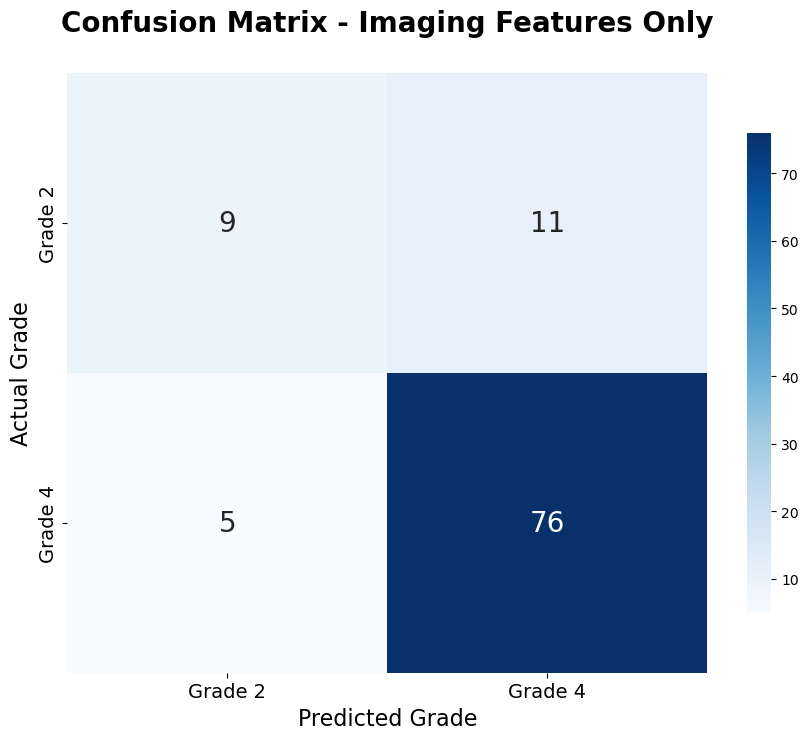

   ✓ Confusion matrix saved as 'PDGM/confusion_matrix_imaging.png'


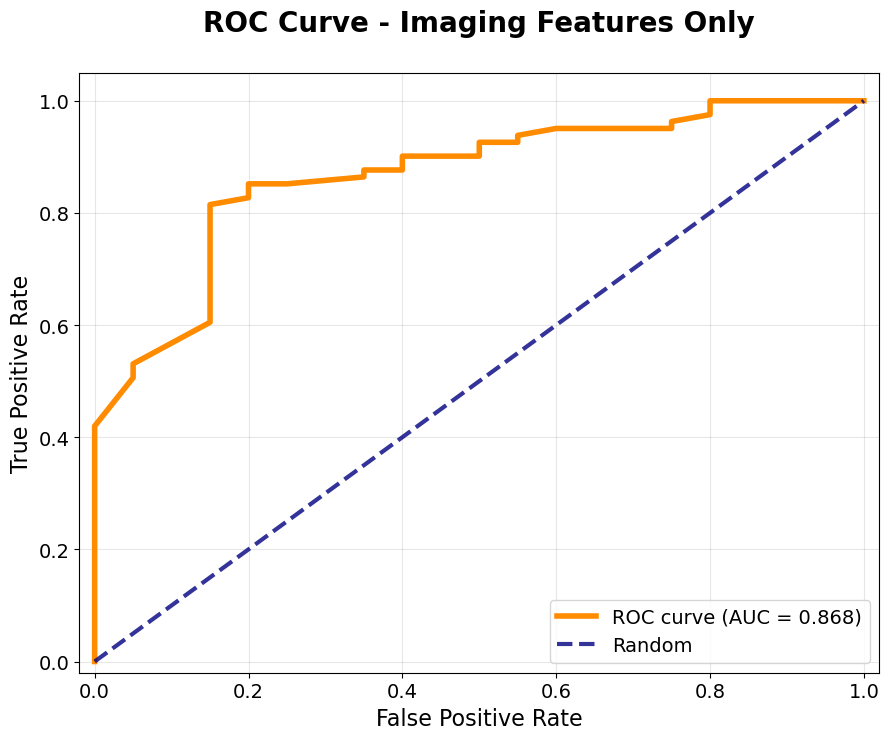

   ✓ ROC curve saved as 'PDGM/roc_curve_imaging.png'


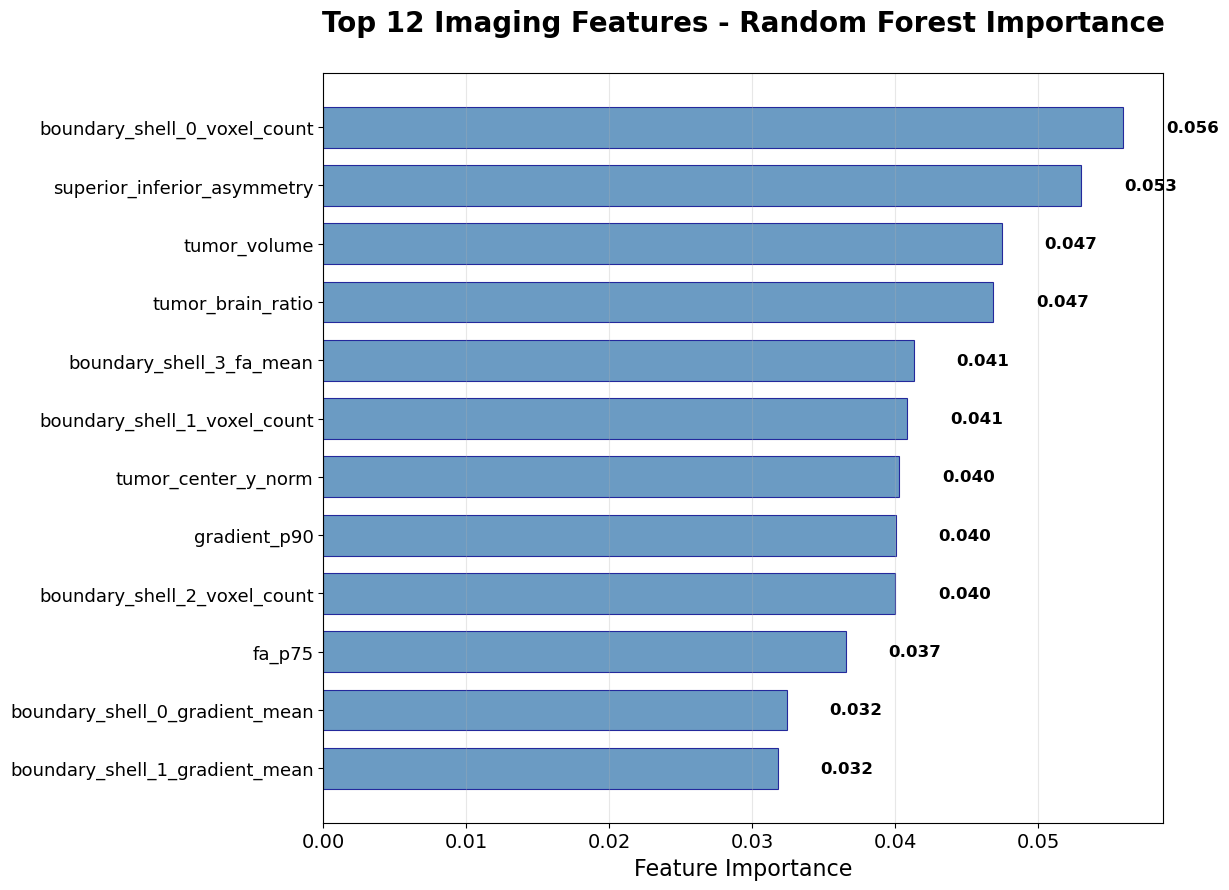

   ✓ Feature importance plot saved as 'PDGM/feature_importance_imaging.png'

   ✓ All individual plots created and saved for PowerPoint use

FEATURE IMPORTANCE ANALYSIS

ALL IMAGING FEATURES RANKED BY IMPORTANCE:
Rank Feature                                              Importance  Cumulative%
--------------------------------------------------------------------------------
   1. boundary_shell_0_voxel_count                    :   0.055972 (   5.6%)
   2. superior_inferior_asymmetry                     :   0.053014 (  10.9%)
   3. tumor_volume                                    :   0.047463 (  15.6%)
   4. tumor_brain_ratio                               :   0.046884 (  20.3%)
   5. boundary_shell_3_fa_mean                        :   0.041313 (  24.5%)
   6. boundary_shell_1_voxel_count                    :   0.040852 (  28.5%)
   7. tumor_center_y_norm                             :   0.040310 (  32.6%)
   8. gradient_p90                                    :   0.040055 (  36.6%)
   9. bo

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           balanced_accuracy_score, roc_curve, auc)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

def run_imaging_only_pipeline():
    """
    Run Random Forest pipeline using only imaging features from the updated metadata files
    """
    print("="*60)
    print("IMAGING-ONLY RANDOM FOREST PIPELINE")
    print("="*60)
    
    # Load the updated metadata files with imaging features
    print("\n1. Loading updated metadata with imaging features...")
    df_train = pd.read_csv('PDGM/train_metadata_with_imaging.csv')
    df_test = pd.read_csv('PDGM/test_metadata_with_imaging.csv')
    
    print(f"   Train data shape: {df_train.shape}")
    print(f"   Test data shape: {df_test.shape}")
    
    # Identify and filter only imaging features
    print("\n2. Filtering imaging features...")
    
    # Columns to exclude (non-imaging features)
    exclude_cols = ['ID', 'WHO CNS Grade']
    
    # Clinical/molecular feature patterns to exclude - MGMT is molecular/clinical!
    clinical_patterns = ['Sex_', 'MGMT', 'mgmt', 'IDH_', 'idh', '1p/19q_', '1p19q', 'Age', 'age']
    
    # Also check for any original clinical columns that might still be present
    clinical_exact_matches = ['MGMT status', 'MGMT index', 'mgmt_status', 'mgmt_index', 
                             'Sex', 'sex', 'IDH', 'idh', 'IDH_status', 'idh_status',
                             '1p/19q', '1p19q', 'Age at MRI', 'age_at_mri', 
                             'EOR', 'eor', 'overall_survival_days']
    
    # Get all column names
    all_cols = df_train.columns.tolist()
    
    # Find clinical columns to exclude (pattern-based)
    clinical_cols = []
    for col in all_cols:
        if any(pattern in col for pattern in clinical_patterns):
            clinical_cols.append(col)
    
    # Find clinical columns to exclude (exact matches)
    clinical_exact = [col for col in all_cols if col in clinical_exact_matches]
    
    # Combine all exclusions
    all_clinical = list(set(clinical_cols + clinical_exact))
    final_exclude = exclude_cols + all_clinical
    
    # Keep only imaging features
    imaging_cols_all = [col for col in all_cols if col not in final_exclude]
    
    # Drop redundant/noisy imaging features for cleaner analysis
    redundant_features = [
        'fa_min', 'fa_max', 'fa_median', 'fa_mode',  # redundant with other stats
        'fa_p5', 'fa_p95', 'fa_p10', 'fa_p90',      # extreme percentiles, noisy
        'fa_std', 'gradient_std', 'hemispheric_asymmetry_std',  # all std features - noisy
        'gradient_median',                           # redundant with gradient_mean
        'superior_fa_mean', 'inferior_fa_mean',      # keep asymmetry ratio instead
        'left_hemisphere_fa_mean', 'right_hemisphere_fa_mean',  # keep asymmetry instead
        # Shell features to exclude
        'shell_0_fa_mean', 'shell_0_fa_std', 'shell_0_fa_median', 'shell_0_voxel_count',
        'shell_1_fa_mean', 'shell_1_fa_std', 'shell_1_fa_median', 'shell_1_voxel_count',
        'shell_2_fa_mean', 'shell_2_fa_std', 'shell_2_fa_median', 'shell_2_voxel_count',
        'shell_3_fa_mean', 'shell_3_fa_std', 'shell_3_fa_median', 'shell_3_voxel_count',
        'shell_0_gradient_mean', 'shell_0_gradient_std',
        'shell_1_gradient_mean', 'shell_1_gradient_std',
        'shell_2_gradient_mean', 'shell_2_gradient_std',
        'shell_3_gradient_mean', 'shell_3_gradient_std'
    ]
    
    # Also remove any other shell-based std features dynamically
    shell_std_features = [col for col in imaging_cols_all if 'shell' in col and '_std' in col and col not in redundant_features]
    redundant_features.extend(shell_std_features)
    
    # Filter out redundant features
    imaging_cols = [col for col in imaging_cols_all if col not in redundant_features]
    
    print(f"   Imaging features before filtering: {len(imaging_cols_all)}")
    print(f"   Redundant features removed: {len(redundant_features)}")
    print(f"   Final imaging features: {len(imaging_cols)}")
    
    # Show which redundant features were actually present and removed
    actually_removed = [col for col in redundant_features if col in imaging_cols_all]
    if actually_removed:
        print(f"   Actually removed: {actually_removed}")
    else:
        print(f"   Note: None of the redundant features were present in dataset")
    
    print(f"   Total columns: {len(all_cols)}")
    print(f"   Excluded columns: {len(final_exclude)}")
    print(f"   Imaging features: {len(imaging_cols)}")
    
    # Print detailed breakdown of features
    print(f"\n" + "="*50)
    print("FEATURE CATEGORIZATION")
    print("="*50)
    
    print(f"\nESSENTIAL COLUMNS (excluded):")
    for col in exclude_cols:
        if col in all_cols:
            print(f"   {col}")
    
    print(f"\nCLINICAL/MOLECULAR FEATURES (excluded):")
    clinical_sorted = sorted(all_clinical)
    for col in clinical_sorted:
        print(f"   {col}")
    
    print(f"\nIMAGING FEATURES (included - showing first 20):")
    imaging_sorted = sorted(imaging_cols)
    for i, col in enumerate(imaging_sorted[:20]):
        print(f"   {col}")
    if len(imaging_cols) > 20:
        print(f"   ... and {len(imaging_cols) - 20} more imaging features")
    
    print(f"\nFEATURE SUMMARY:")
    print(f"   Clinical/molecular features excluded: {len(all_clinical)}")
    print(f"   Imaging features included: {len(imaging_cols)}")
    print(f"   Essential columns excluded: {len([c for c in exclude_cols if c in all_cols])}")
    print(f"   Total columns in dataset: {len(all_cols)}")
    
    # Save feature lists for reference
    feature_breakdown = {
        'clinical_molecular_features': clinical_sorted,
        'imaging_features': imaging_sorted,
        'excluded_essential': [c for c in exclude_cols if c in all_cols],
        'total_columns': len(all_cols)
    }
    
    import json
    with open('PDGM/feature_breakdown.json', 'w') as f:
        json.dump(feature_breakdown, f, indent=2)
    print(f"   ✓ Feature breakdown saved to 'PDGM/feature_breakdown.json'")
    
    # Prepare features and targets
    print("\n3. Preparing features and targets...")
    X_train = df_train[imaging_cols].copy()
    X_test = df_test[imaging_cols].copy()
    y_train = df_train['WHO CNS Grade'].copy()
    y_test = df_test['WHO CNS Grade'].copy()
    
    print(f"   X_train shape: {X_train.shape}")
    print(f"   X_test shape: {X_test.shape}")
    print(f"   y_train shape: {y_train.shape}")
    print(f"   y_test shape: {y_test.shape}")
    
    # Check for any remaining missing values
    train_missing = X_train.isna().sum().sum()
    test_missing = X_test.isna().sum().sum()
    
    if train_missing > 0 or test_missing > 0:
        print(f"   WARNING: Missing values - Train: {train_missing}, Test: {test_missing}")
        # Fill any remaining missing values
        X_train = X_train.fillna(X_train.median())
        X_test = X_test.fillna(X_train.median())  # Use train median for test
        print(f"   Missing values filled with median")
    
    # Check grade distribution
    print(f"\n4. Class distribution:")
    train_dist = y_train.value_counts().sort_index()
    test_dist = y_test.value_counts().sort_index()
    
    for grade in sorted(y_train.unique()):
        train_pct = (y_train == grade).mean() * 100
        test_pct = (y_test == grade).mean() * 100
        print(f"   Grade {grade} - Train: {train_pct:.1f}%, Test: {test_pct:.1f}%")
    
    # Compute class weights to address imbalance
    print("\n5. Computing class weights...")
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, weights))
    
    print(f"   Classes: {classes}")
    print(f"   Weights: {weights}")
    print(f"   Class weight dict: {class_weight_dict}")
    
    # Define the pipeline (scaling + random forest)
    print("\n6. Setting up pipeline...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(
            n_estimators=100,
            class_weight=class_weight_dict,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    print("   Pipeline components:")
    print("   - StandardScaler for feature normalization")
    print("   - RandomForestClassifier with balanced class weights")
    
    # Train model on training set only
    print("\n7. Training model on training set...")
    pipeline.fit(X_train, y_train)
    
    # Evaluate training performance (just for reference)
    print("\n8. Training set performance (for reference only)...")
    y_train_pred = pipeline.predict(X_train)
    train_accuracy = (y_train_pred == y_train).mean()
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
    
    print(f"   Training Accuracy: {train_accuracy:.4f}")
    print(f"   Training Balanced Accuracy: {train_balanced_accuracy:.4f}")
    print("   (Note: Training performance may be optimistic due to overfitting)")
    
    # Evaluate on held-out test set
    print("\n9. Test set evaluation (true performance)...")
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    
    # Calculate additional metrics
    test_accuracy = (y_pred == y_test).mean()
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    
    # For ROC-AUC, we need to handle multiclass
    unique_classes = sorted(y_test.unique())
    n_classes = len(unique_classes)
    
    if n_classes == 2:
        # Binary classification
        test_roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        print(f"   Test Accuracy: {test_accuracy:.4f}")
        print(f"   Test Balanced Accuracy: {test_balanced_accuracy:.4f}")
        print(f"   Test ROC-AUC: {test_roc_auc:.4f}")
        
        # Plot ROC curve for binary classification
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=unique_classes[1])
        
    else:
        # Multiclass classification
        test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
        print(f"   Test Accuracy: {test_accuracy:.4f}")
        print(f"   Test Balanced Accuracy: {test_balanced_accuracy:.4f}")
        print(f"   Test ROC-AUC (weighted): {test_roc_auc:.4f}")
        
        # For multiclass, we'll plot ROC curves for each class vs rest
        y_test_bin = label_binarize(y_test, classes=unique_classes)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i, class_label in enumerate(unique_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
    print("\n" + "="*60)
    print("DETAILED RESULTS")
    print("="*60)
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Print confusion matrix with labels for clarity
    unique_labels = sorted(y_test.unique())
    print(f"\nConfusion Matrix (rows=actual, cols=predicted):")
    print(f"{'':>8}", end="")
    for label in unique_labels:
        print(f"{f'Pred_{label}':>8}", end="")
    print()
    
    for i, actual_label in enumerate(unique_labels):
        print(f"True_{actual_label}:", end="")
        for j, pred_label in enumerate(unique_labels):
            print(f"{cm[i,j]:>8}", end="")
        print()
    
    # Feature importance analysis (MOVED BEFORE VISUALIZATIONS)
    print("\n" + "="*60)
    print("IMAGING FEATURE IMPORTANCE")
    print("="*60)
    
    # Get feature importance from the trained random forest
    rf_model = pipeline.named_steps['rf']
    feature_importance = rf_model.feature_importances_
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': imaging_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"\nALL IMAGING FEATURES RANKED BY IMPORTANCE:")
    print(f"{'Rank':>4} {'Feature':50} {'Importance':>12} {'Cumulative%':>12}")
    print("-" * 80)
    
    cumulative_importance = 0
    for i, (_, row) in enumerate(importance_df.iterrows()):
        cumulative_importance += row['importance']
        cumulative_pct = cumulative_importance / importance_df['importance'].sum() * 100
        print(f"{i+1:4d}. {row['feature']:48s}: {row['importance']:10.6f} ({cumulative_pct:6.1f}%)")
    
    # Summary statistics
    print(f"\nFeature Importance Summary:")
    print(f"   Total features: {len(importance_df)}")
    print(f"   Mean importance: {feature_importance.mean():.6f}")
    print(f"   Std importance: {feature_importance.std():.6f}")
    print(f"   Min importance: {feature_importance.min():.6f}")
    print(f"   Max importance: {feature_importance.max():.6f}")
    print(f"   Top 5 features account for: {importance_df.head(5)['importance'].sum():.1%} of total importance")
    print(f"   Top 10 features account for: {importance_df.head(10)['importance'].sum():.1%} of total importance")
    print(f"   Bottom 50% features account for: {importance_df.tail(len(importance_df)//2)['importance'].sum():.1%} of total importance")
    
    # Create visualizations (NOW AFTER importance_df IS CREATED)
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. CONFUSION MATRIX HEATMAP (Separate plot)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[f'Grade {i}' for i in unique_labels],
                yticklabels=[f'Grade {i}' for i in unique_labels],
                annot_kws={'size': 20}, cbar_kws={'shrink': 0.8})
    plt.title('Confusion Matrix - Imaging Features Only', fontsize=20, fontweight='bold', pad=30)
    plt.xlabel('Predicted Grade', fontsize=16)
    plt.ylabel('Actual Grade', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/confusion_matrix_imaging.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Confusion matrix saved as 'PDGM/confusion_matrix_imaging.png'")
    
    # 2. ROC CURVE (Separate plot)
    plt.figure(figsize=(10, 8))
    if n_classes == 2:
        # Binary ROC curve
        plt.plot(fpr, tpr, color='darkorange', lw=4, 
                label=f'ROC curve (AUC = {test_roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', alpha=0.8, label='Random')
        plt.xlim([-0.02, 1.02])
        plt.ylim([-0.02, 1.05])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC Curve - Imaging Features Only', fontsize=20, fontweight='bold', pad=30)
        plt.legend(loc="lower right", fontsize=14)
        plt.grid(True, alpha=0.3)
    else:
        # Multiclass ROC curves
        colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
        for i, (class_label, color) in enumerate(zip(unique_classes, colors)):
            plt.plot(fpr[i], tpr[i], color=color, lw=4,
                    label=f'Grade {class_label} (AUC = {roc_auc[i]:.3f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', alpha=0.8, label='Random')
        plt.xlim([-0.02, 1.02])
        plt.ylim([-0.02, 1.05])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC Curves - Imaging Features Only', fontsize=20, fontweight='bold', pad=30)
        plt.legend(loc="lower right", fontsize=13)
        plt.grid(True, alpha=0.3)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/roc_curve_imaging.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ ROC curve saved as 'PDGM/roc_curve_imaging.png'")
    
    # 3. FEATURE IMPORTANCE (Separate plot)
    plt.figure(figsize=(12, 10))
    top_features = importance_df.head(12)  # Show top 12 for better spacing
    bars = plt.barh(range(len(top_features)), top_features['importance'], 
                    color='steelblue', alpha=0.8, edgecolor='darkblue', linewidth=0.8, height=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=13)
    plt.xlabel('Feature Importance', fontsize=16)
    plt.title('Top 12 Imaging Features - Random Forest Importance', fontsize=20, fontweight='bold', pad=30)
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.003, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=12, fontweight='bold')
    
    plt.grid(axis='x', alpha=0.3)
    plt.xticks(fontsize=14)
    plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/feature_importance_imaging.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Feature importance plot saved as 'PDGM/feature_importance_imaging.png'")
    
    print("\n   ✓ All individual plots created and saved for PowerPoint use")

    
    # Feature importance analysis
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Get feature importance from the trained random forest
    rf_model = pipeline.named_steps['rf']
    feature_importance = rf_model.feature_importances_
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': imaging_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"\nALL IMAGING FEATURES RANKED BY IMPORTANCE:")
    print(f"{'Rank':>4} {'Feature':50} {'Importance':>12} {'Cumulative%':>12}")
    print("-" * 80)
    
    cumulative_importance = 0
    for i, (_, row) in enumerate(importance_df.iterrows()):
        cumulative_importance += row['importance']
        cumulative_pct = cumulative_importance / importance_df['importance'].sum() * 100
        print(f"{i+1:4d}. {row['feature']:48s}: {row['importance']:10.6f} ({cumulative_pct:6.1f}%)")
    
    # Summary statistics
    print(f"\nFeature Importance Summary:")
    print(f"   Total features: {len(importance_df)}")
    print(f"   Mean importance: {feature_importance.mean():.6f}")
    print(f"   Std importance: {feature_importance.std():.6f}")
    print(f"   Min importance: {feature_importance.min():.6f}")
    print(f"   Max importance: {feature_importance.max():.6f}")
    print(f"   Top 5 features account for: {importance_df.head(5)['importance'].sum():.1%} of total importance")
    print(f"   Top 10 features account for: {importance_df.head(10)['importance'].sum():.1%} of total importance")
    print(f"   Bottom 50% features account for: {importance_df.tail(len(importance_df)//2)['importance'].sum():.1%} of total importance")
    
    # Save results
    print("\n" + "="*60)
    print("SAVING RESULTS")
    print("="*60)
    
    # Save feature importance
    importance_df.to_csv('PDGM/imaging_feature_importance.csv', index=False)
    print("   ✓ Feature importance saved to 'PDGM/imaging_feature_importance.csv'")
    
    # Save predictions
    results_df = pd.DataFrame({
        'ID': df_test['ID'],
        'true_grade': y_test,
        'predicted_grade': y_pred,
        'prediction_probability': y_pred_proba.max(axis=1)
    })
    results_df.to_csv('PDGM/test_predictions.csv', index=False)
    print("   ✓ Test predictions saved to 'PDGM/test_predictions.csv'")
    
    # Save model performance summary
    performance_summary = {
        'train_accuracy': float(train_accuracy),
        'train_balanced_accuracy': float(train_balanced_accuracy),
        'test_accuracy': float(test_accuracy),
        'test_balanced_accuracy': float(test_balanced_accuracy),
        'test_roc_auc': float(test_roc_auc),
        'n_imaging_features': len(imaging_cols),
        'n_train_samples': len(X_train),
        'n_test_samples': len(X_test)
    }
    
    import json
    with open('PDGM/performance_summary.json', 'w') as f:
        json.dump(performance_summary, f, indent=2)
    print("   ✓ Performance summary saved to 'PDGM/performance_summary.json'")
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)
    print(f"Using {len(imaging_cols)} imaging features only")
    print(f"Training accuracy: {train_accuracy:.3f} (may be optimistic)")
    print(f"Test set accuracy: {test_accuracy:.3f} (true performance)")
    print(f"Test set balanced accuracy: {test_balanced_accu4racy:.3f}")
    
    return pipeline, importance_df, performance_summary

if __name__ == "__main__":
    # Run the imaging-only pipeline
    model, feature_importance, performance = run_imaging_only_pipeline()

IMAGING + CLINICAL FEATURES PIPELINE

1. Loading updated metadata with imaging + clinical features...
   Train data shape: (399, 94)
   Test data shape: (101, 94)

2. Categorizing imaging and clinical features...
   Total columns: 94
   Imaging features (after filtering): 41
   Clinical features: 11
   Total features used: 52
   Redundant imaging features removed: ['fa_min', 'fa_max', 'fa_median', 'fa_mode', 'fa_p5', 'fa_p95', 'fa_p10', 'fa_p90', 'fa_std', 'gradient_std', 'hemispheric_asymmetry_std', 'gradient_median', 'superior_fa_mean', 'inferior_fa_mean', 'left_hemisphere_fa_mean', 'right_hemisphere_fa_mean', 'shell_0_fa_mean', 'shell_0_fa_std', 'shell_0_fa_median', 'shell_0_voxel_count', 'shell_1_fa_mean', 'shell_1_fa_std', 'shell_1_fa_median', 'shell_1_voxel_count', 'shell_2_fa_mean', 'shell_2_fa_std', 'shell_2_fa_median', 'shell_2_voxel_count', 'shell_3_fa_mean', 'shell_3_fa_std', 'shell_3_fa_median', 'shell_3_voxel_count', 'shell_0_gradient_mean', 'shell_0_gradient_std', 'shell_

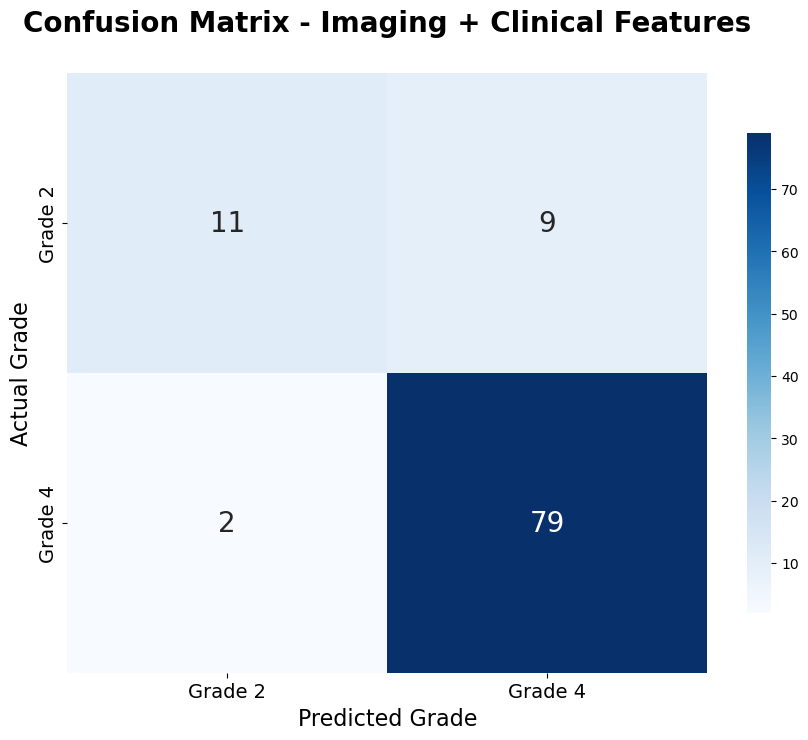

   ✓ Confusion matrix saved as 'PDGM/confusion_matrix_combined.png'


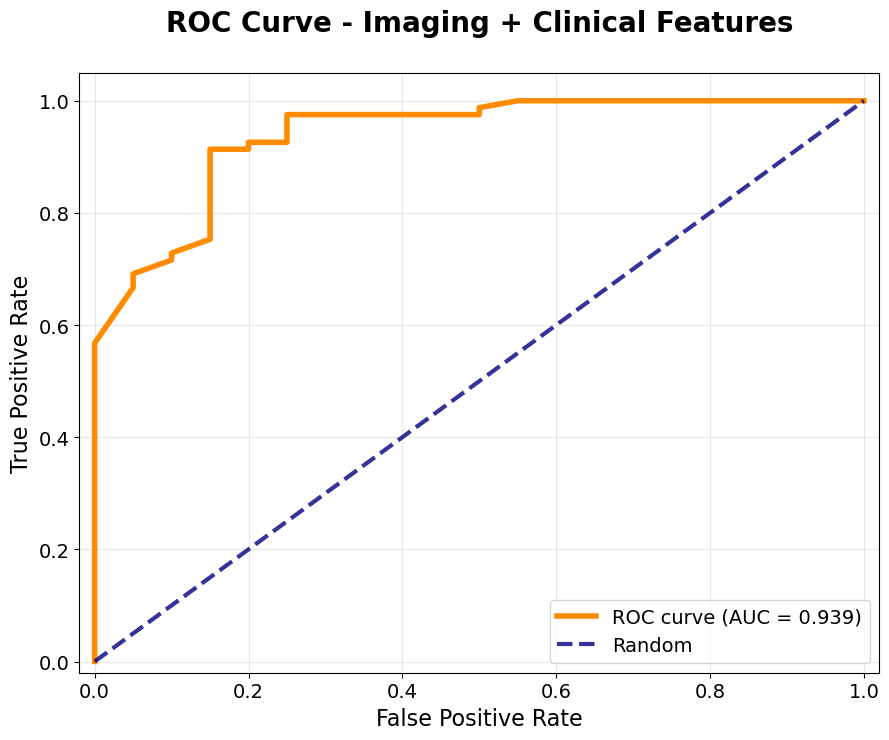

   ✓ ROC curve saved as 'PDGM/roc_curve_combined.png'


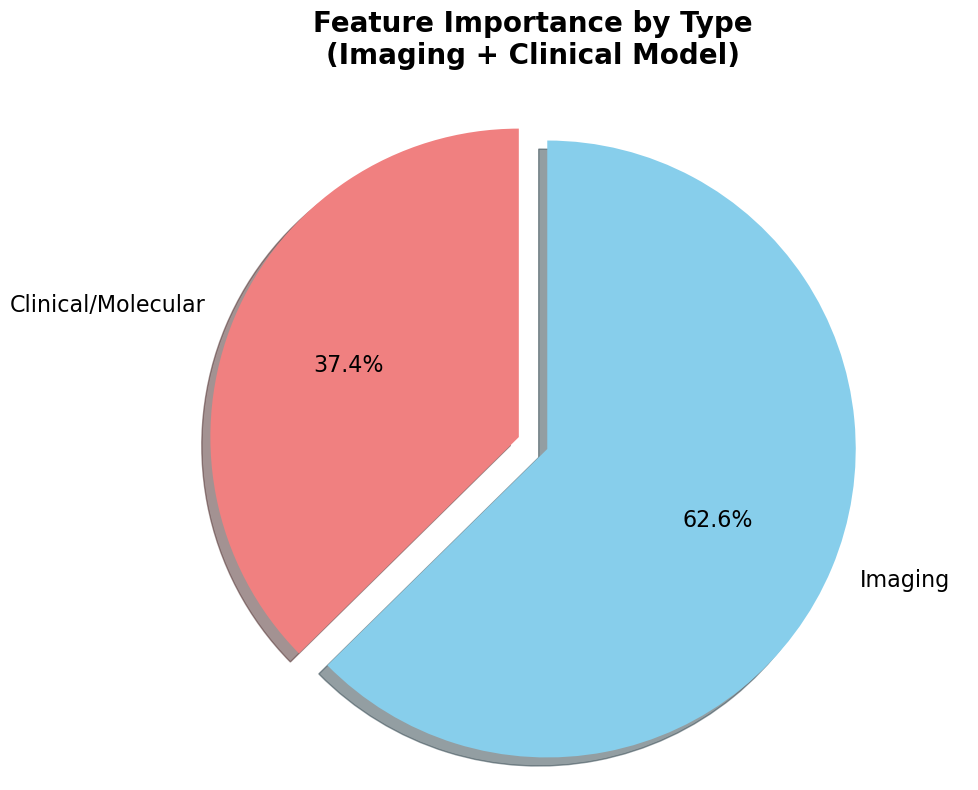

   ✓ Feature importance pie chart saved as 'PDGM/feature_importance_pie_combined.png'


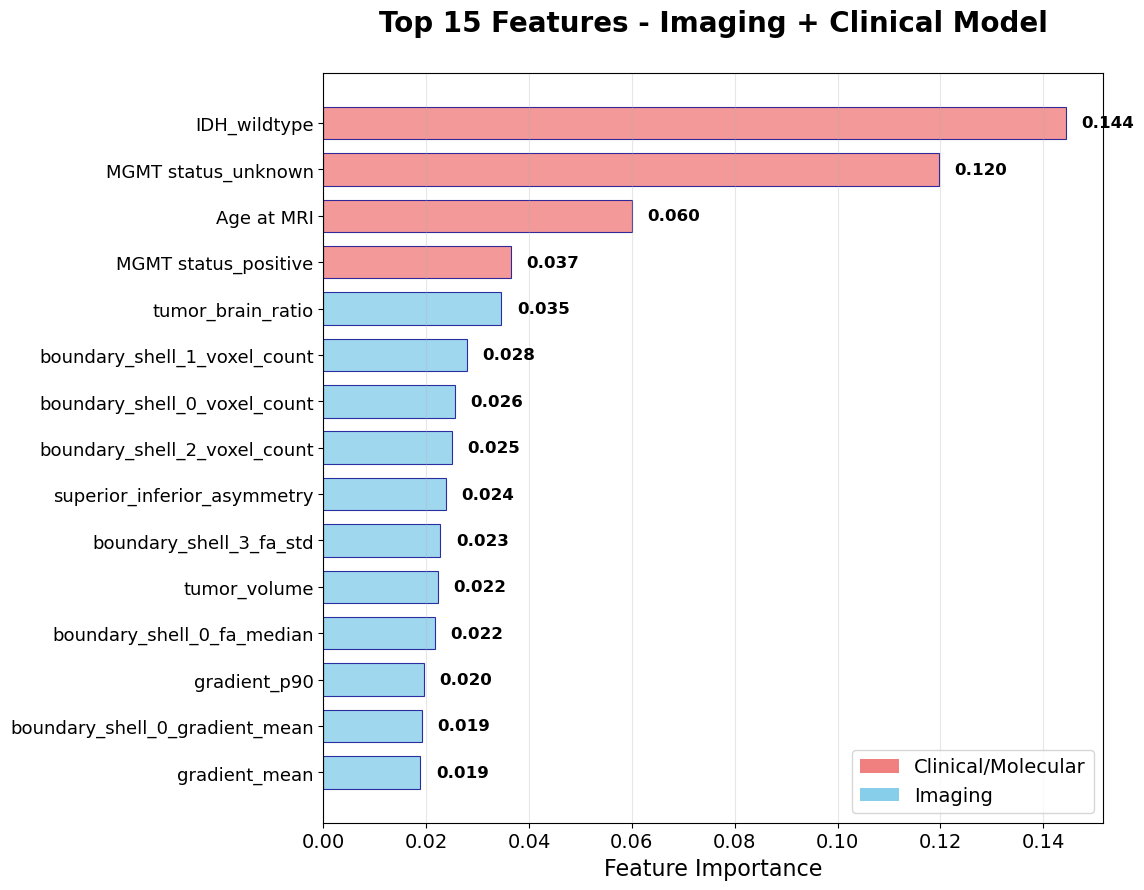

   ✓ Feature importance plot saved as 'PDGM/feature_importance_combined.png'

   ✓ All individual plots created and saved for PowerPoint use

SAVING RESULTS
   ✓ Feature importance saved to 'PDGM/combined_feature_importance.csv'
   ✓ Test predictions saved to 'PDGM/test_predictions_combined.csv'
   ✓ Performance summary saved to 'PDGM/performance_summary_combined.json'

ANALYSIS COMPLETE!
Using 41 imaging + 11 clinical features
Training accuracy: 1.000 (may be optimistic)
Test set accuracy: 0.891 (true performance)
Test set balanced accuracy: 0.763
Clinical features contribute: 37.4% of importance
Imaging features contribute: 62.6% of importance


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           balanced_accuracy_score, roc_curve, auc)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

def run_imaging_clinical_pipeline():
    """
    Run Random Forest pipeline using BOTH imaging AND clinical features
    """
    print("="*60)
    print("IMAGING + CLINICAL FEATURES PIPELINE")
    print("="*60)
    
    # Load the updated metadata files with imaging features
    print("\n1. Loading updated metadata with imaging + clinical features...")
    df_train = pd.read_csv('PDGM/train_metadata_with_imaging.csv')
    df_test = pd.read_csv('PDGM/test_metadata_with_imaging.csv')
    
    print(f"   Train data shape: {df_train.shape}")
    print(f"   Test data shape: {df_test.shape}")
    
    # Identify imaging and clinical features separately
    print("\n2. Categorizing imaging and clinical features...")
    
    # Columns to exclude (target and ID)
    exclude_cols = ['ID', 'WHO CNS Grade']
    
    # Get all column names
    all_cols = df_train.columns.tolist()
    
    # Clinical/molecular feature patterns (these will be INCLUDED this time)
    clinical_patterns = ['Sex_', 'MGMT', 'mgmt', 'IDH_', 'idh', '1p/19q_', '1p19q', 'Age', 'age']
    clinical_exact_matches = ['MGMT status', 'MGMT index', 'mgmt_status', 'mgmt_index', 
                             'Sex', 'sex', 'IDH', 'idh', 'IDH_status', 'idh_status',
                             '1p/19q', '1p19q', 'Age at MRI', 'age_at_mri']
    
    # Find clinical columns
    clinical_cols = []
    for col in all_cols:
        if any(pattern in col for pattern in clinical_patterns):
            clinical_cols.append(col)
    
    clinical_exact = [col for col in all_cols if col in clinical_exact_matches]
    all_clinical = list(set(clinical_cols + clinical_exact))
    
    # Remove redundant/noisy imaging features (same as imaging-only model)
    redundant_features = [
        'fa_min', 'fa_max', 'fa_median', 'fa_mode',  # redundant with other stats
        'fa_p5', 'fa_p95', 'fa_p10', 'fa_p90',      # extreme percentiles, noisy
        'fa_std', 'gradient_std', 'hemispheric_asymmetry_std',  # all std features - noisy
        'gradient_median',                           # redundant with gradient_mean
        'superior_fa_mean', 'inferior_fa_mean',      # keep asymmetry ratio instead
        'left_hemisphere_fa_mean', 'right_hemisphere_fa_mean',  # keep asymmetry instead
        # Shell features to exclude (same as imaging-only)
        'shell_0_fa_mean', 'shell_0_fa_std', 'shell_0_fa_median', 'shell_0_voxel_count',
        'shell_1_fa_mean', 'shell_1_fa_std', 'shell_1_fa_median', 'shell_1_voxel_count',
        'shell_2_fa_mean', 'shell_2_fa_std', 'shell_2_fa_median', 'shell_2_voxel_count',
        'shell_3_fa_mean', 'shell_3_fa_std', 'shell_3_fa_median', 'shell_3_voxel_count',
        'shell_0_gradient_mean', 'shell_0_gradient_std',
        'shell_1_gradient_mean', 'shell_1_gradient_std',
        'shell_2_gradient_mean', 'shell_2_gradient_std',
        'shell_3_gradient_mean', 'shell_3_gradient_std'
    ]
    
    # Get all feature columns (excluding only ID and target)
    all_feature_cols = [col for col in all_cols if col not in exclude_cols]
    
    # Separate imaging and clinical
    imaging_cols_all = [col for col in all_feature_cols if col not in all_clinical]
    clinical_cols_final = [col for col in all_feature_cols if col in all_clinical]
    
    # Filter out redundant imaging features
    imaging_cols_final = [col for col in imaging_cols_all if col not in redundant_features]
    
    # Combine imaging and clinical features
    final_feature_cols = imaging_cols_final + clinical_cols_final
    
    print(f"   Total columns: {len(all_cols)}")
    print(f"   Imaging features (after filtering): {len(imaging_cols_final)}")
    print(f"   Clinical features: {len(clinical_cols_final)}")
    print(f"   Total features used: {len(final_feature_cols)}")
    
    # Show which redundant features were actually present and removed
    actually_removed = [col for col in redundant_features if col in imaging_cols_all]
    if actually_removed:
        print(f"   Redundant imaging features removed: {actually_removed}")
    
    # Print detailed breakdown of features
    print(f"\n" + "="*50)
    print("FEATURE CATEGORIZATION")
    print("="*50)
    
    print(f"\nCLINICAL/MOLECULAR FEATURES (included):")
    clinical_sorted = sorted(clinical_cols_final)
    for col in clinical_sorted:
        print(f"   {col}")
    
    print(f"\nIMAGING FEATURES (included - showing first 15):")
    imaging_sorted = sorted(imaging_cols_final)
    for i, col in enumerate(imaging_sorted[:15]):
        print(f"   {col}")
    if len(imaging_cols_final) > 15:
        print(f"   ... and {len(imaging_cols_final) - 15} more imaging features")
    
    print(f"\nFEATURE SUMMARY:")
    print(f"   Clinical/molecular features: {len(clinical_cols_final)}")
    print(f"   Imaging features: {len(imaging_cols_final)}")
    print(f"   Total features: {len(final_feature_cols)}")
    
    # Save feature lists for reference
    feature_breakdown = {
        'clinical_features': clinical_sorted,
        'imaging_features': imaging_sorted,
        'all_features_used': sorted(final_feature_cols),
        'redundant_removed': actually_removed,
        'total_features': len(final_feature_cols)
    }
    
    import json
    with open('PDGM/feature_breakdown_combined.json', 'w') as f:
        json.dump(feature_breakdown, f, indent=2)
    print(f"   ✓ Feature breakdown saved to 'PDGM/feature_breakdown_combined.json'")
    
    # Prepare features and targets
    print("\n3. Preparing features and targets...")
    X_train = df_train[final_feature_cols].copy()
    X_test = df_test[final_feature_cols].copy()
    y_train = df_train['WHO CNS Grade'].copy()
    y_test = df_test['WHO CNS Grade'].copy()
    
    print(f"   X_train shape: {X_train.shape}")
    print(f"   X_test shape: {X_test.shape}")
    print(f"   y_train shape: {y_train.shape}")
    print(f"   y_test shape: {y_test.shape}")
    
    # Check for any remaining missing values
    train_missing = X_train.isna().sum().sum()
    test_missing = X_test.isna().sum().sum()
    
    if train_missing > 0 or test_missing > 0:
        print(f"   WARNING: Missing values - Train: {train_missing}, Test: {test_missing}")
        # Fill any remaining missing values
        X_train = X_train.fillna(X_train.median())
        X_test = X_test.fillna(X_train.median())  # Use train median for test
        print(f"   Missing values filled with median")
    
    # Check grade distribution
    print(f"\n4. Class distribution:")
    train_dist = y_train.value_counts().sort_index()
    test_dist = y_test.value_counts().sort_index()
    
    for grade in sorted(y_train.unique()):
        train_pct = (y_train == grade).mean() * 100
        test_pct = (y_test == grade).mean() * 100
        print(f"   Grade {grade} - Train: {train_pct:.1f}%, Test: {test_pct:.1f}%")
    
    # Compute class weights to address imbalance
    print("\n5. Computing class weights...")
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, weights))
    
    print(f"   Classes: {classes}")
    print(f"   Weights: {weights}")
    print(f"   Class weight dict: {class_weight_dict}")
    
    # Define the pipeline (scaling + random forest)
    print("\n6. Setting up pipeline...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(
            n_estimators=100,
            class_weight=class_weight_dict,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    print("   Pipeline components:")
    print("   - StandardScaler for feature normalization")
    print("   - RandomForestClassifier with balanced class weights")
    
    # Train model on training set only
    print("\n7. Training model on training set...")
    pipeline.fit(X_train, y_train)
    
    # Evaluate training performance (just for reference)
    print("\n8. Training set performance (for reference only)...")
    y_train_pred = pipeline.predict(X_train)
    train_accuracy = (y_train_pred == y_train).mean()
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
    
    print(f"   Training Accuracy: {train_accuracy:.4f}")
    print(f"   Training Balanced Accuracy: {train_balanced_accuracy:.4f}")
    print("   (Note: Training performance may be optimistic due to overfitting)")
    
    # Evaluate on held-out test set
    print("\n9. Test set evaluation (true performance)...")
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    
    # Calculate additional metrics
    test_accuracy = (y_pred == y_test).mean()
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    
    # For ROC-AUC, we need to handle multiclass
    unique_classes = sorted(y_test.unique())
    n_classes = len(unique_classes)
    
    if n_classes == 2:
        # Binary classification
        test_roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        print(f"   Test Accuracy: {test_accuracy:.4f}")
        print(f"   Test Balanced Accuracy: {test_balanced_accuracy:.4f}")
        print(f"   Test ROC-AUC: {test_roc_auc:.4f}")
        
        # Plot ROC curve for binary classification
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=unique_classes[1])
        
    else:
        # Multiclass classification
        test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
        print(f"   Test Accuracy: {test_accuracy:.4f}")
        print(f"   Test Balanced Accuracy: {test_balanced_accuracy:.4f}")
        print(f"   Test ROC-AUC (weighted): {test_roc_auc:.4f}")
        
        # For multiclass, we'll plot ROC curves for each class vs rest
        y_test_bin = label_binarize(y_test, classes=unique_classes)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i, class_label in enumerate(unique_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
    print("\n" + "="*60)
    print("DETAILED RESULTS")
    print("="*60)
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Print confusion matrix with labels for clarity
    unique_labels = sorted(y_test.unique())
    print(f"\nConfusion Matrix (rows=actual, cols=predicted):")
    print(f"{'':>8}", end="")
    for label in unique_labels:
        print(f"{f'Pred_{label}':>8}", end="")
    print()
    
    for i, actual_label in enumerate(unique_labels):
        print(f"True_{actual_label}:", end="")
        for j, pred_label in enumerate(unique_labels):
            print(f"{cm[i,j]:>8}", end="")
        print()
    
    # Feature importance analysis (MOVED BEFORE VISUALIZATIONS)
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Get feature importance from the trained random forest
    rf_model = pipeline.named_steps['rf']
    feature_importance = rf_model.feature_importances_
    
    # Create feature importance DataFrame with feature type classification
    importance_df = pd.DataFrame({
        'feature': final_feature_cols,
        'importance': feature_importance,
        'feature_type': ['clinical' if f in clinical_cols_final else 'imaging' for f in final_feature_cols]
    }).sort_values('importance', ascending=False)
    
    print(f"\nALL FEATURES RANKED BY IMPORTANCE:")
    print(f"{'Rank':>4} {'Type':>8} {'Feature':45} {'Importance':>12} {'Cumulative%':>12}")
    print("-" * 85)
    
    cumulative_importance = 0
    for i, (_, row) in enumerate(importance_df.iterrows()):
        cumulative_importance += row['importance']
        cumulative_pct = cumulative_importance / importance_df['importance'].sum() * 100
        print(f"{i+1:4d}. {row['feature_type']:>8} {row['feature']:43s}: {row['importance']:10.6f} ({cumulative_pct:6.1f}%)")
    
    # Analyze importance by feature type
    clinical_importance = importance_df[importance_df['feature_type'] == 'clinical']['importance'].sum()
    imaging_importance = importance_df[importance_df['feature_type'] == 'imaging']['importance'].sum()
    total_importance = importance_df['importance'].sum()
    
    print(f"\nFEATURE TYPE IMPORTANCE ANALYSIS:")
    print(f"   Clinical features: {clinical_importance:.4f} ({clinical_importance/total_importance:.1%})")
    print(f"   Imaging features: {imaging_importance:.4f} ({imaging_importance/total_importance:.1%})")
    
    # Top features by type
    top_clinical = importance_df[importance_df['feature_type'] == 'clinical'].head(5)
    top_imaging = importance_df[importance_df['feature_type'] == 'imaging'].head(5)
    
    print(f"\nTOP 5 CLINICAL FEATURES:")
    for i, (_, row) in enumerate(top_clinical.iterrows()):
        print(f"   {i+1}. {row['feature']:40s}: {row['importance']:.6f}")
    
    print(f"\nTOP 5 IMAGING FEATURES:")
    for i, (_, row) in enumerate(top_imaging.iterrows()):
        print(f"   {i+1}. {row['feature']:40s}: {row['importance']:.6f}")
    
    # Summary statistics
    print(f"\nFeature Importance Summary:")
    print(f"   Total features: {len(importance_df)}")
    print(f"   Mean importance: {feature_importance.mean():.6f}")
    print(f"   Std importance: {feature_importance.std():.6f}")
    print(f"   Top 5 features account for: {importance_df.head(5)['importance'].sum():.1%} of total importance")
    print(f"   Top 10 features account for: {importance_df.head(10)['importance'].sum():.1%} of total importance")
    
    # Create visualizations
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. CONFUSION MATRIX HEATMAP (Separate plot)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[f'Grade {i}' for i in unique_labels],
                yticklabels=[f'Grade {i}' for i in unique_labels],
                annot_kws={'size': 20}, cbar_kws={'shrink': 0.8})
    plt.title('Confusion Matrix - Imaging + Clinical Features', fontsize=20, fontweight='bold', pad=30)
    plt.xlabel('Predicted Grade', fontsize=16)
    plt.ylabel('Actual Grade', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/confusion_matrix_combined.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Confusion matrix saved as 'PDGM/confusion_matrix_combined.png'")
    
    # 2. ROC CURVE (Separate plot)
    plt.figure(figsize=(10, 8))
    if n_classes == 2:
        # Binary ROC curve
        plt.plot(fpr, tpr, color='darkorange', lw=4, 
                label=f'ROC curve (AUC = {test_roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', alpha=0.8, label='Random')
        plt.xlim([-0.02, 1.02])
        plt.ylim([-0.02, 1.05])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC Curve - Imaging + Clinical Features', fontsize=20, fontweight='bold', pad=30)
        plt.legend(loc="lower right", fontsize=14)
        plt.grid(True, alpha=0.3)
    else:
        # Multiclass ROC curves
        colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
        for i, (class_label, color) in enumerate(zip(unique_classes, colors)):
            plt.plot(fpr[i], tpr[i], color=color, lw=4,
                    label=f'Grade {class_label} (AUC = {roc_auc[i]:.3f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', alpha=0.8, label='Random')
        plt.xlim([-0.02, 1.02])
        plt.ylim([-0.02, 1.05])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC Curves - Imaging + Clinical Features', fontsize=20, fontweight='bold', pad=30)
        plt.legend(loc="lower right", fontsize=13)
        plt.grid(True, alpha=0.3)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/roc_curve_combined.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ ROC curve saved as 'PDGM/roc_curve_combined.png'")
    
    # 3. FEATURE IMPORTANCE BY TYPE (Pie Chart - Separate plot)
    plt.figure(figsize=(10, 8))
    sizes = [clinical_importance, imaging_importance]
    labels = ['Clinical/Molecular', 'Imaging']
    colors = ['lightcoral', 'skyblue']
    explode = (0.05, 0.05)  # slightly separate slices
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, 
            explode=explode, shadow=True, textprops={'fontsize': 16})
    plt.title('Feature Importance by Type\n(Imaging + Clinical Model)', fontsize=20, fontweight='bold', pad=30)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('PDGM/feature_importance_pie_combined.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Feature importance pie chart saved as 'PDGM/feature_importance_pie_combined.png'")
    
    # 4. TOP FEATURES BY TYPE (Separate plot)
    plt.figure(figsize=(12, 10))
    top_features = importance_df.head(15)
    colors = ['lightcoral' if ft == 'clinical' else 'skyblue' for ft in top_features['feature_type']]
    bars = plt.barh(range(len(top_features)), top_features['importance'], 
                    color=colors, alpha=0.8, edgecolor='darkblue', linewidth=0.8, height=0.7)
    
    # Truncate long feature names for better display
    feature_names = [f"{ft[:35]}..." if len(ft) > 38 else ft for ft in top_features['feature']]
    plt.yticks(range(len(top_features)), feature_names, fontsize=13)
    plt.xlabel('Feature Importance', fontsize=16)
    plt.title('Top 15 Features - Imaging + Clinical Model', fontsize=20, fontweight='bold', pad=30)
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.003, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=12, fontweight='bold')
    
    # Add legend for colors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightcoral', label='Clinical/Molecular'),
                      Patch(facecolor='skyblue', label='Imaging')]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=14)
    
    plt.grid(axis='x', alpha=0.3)
    plt.xticks(fontsize=14)
    plt.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/feature_importance_combined.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Feature importance plot saved as 'PDGM/feature_importance_combined.png'")
    
    print("\n   ✓ All individual plots created and saved for PowerPoint use")
    
    # Save results
    print("\n" + "="*60)
    print("SAVING RESULTS")
    print("="*60)
    
    # Save feature importance
    importance_df.to_csv('PDGM/combined_feature_importance.csv', index=False)
    print("   ✓ Feature importance saved to 'PDGM/combined_feature_importance.csv'")
    
    # Save predictions
    results_df = pd.DataFrame({
        'ID': df_test['ID'],
        'true_grade': y_test,
        'predicted_grade': y_pred,
        'prediction_probability': y_pred_proba.max(axis=1)
    })
    results_df.to_csv('PDGM/test_predictions_combined.csv', index=False)
    print("   ✓ Test predictions saved to 'PDGM/test_predictions_combined.csv'")
    
    # Save model performance summary
    performance_summary = {
        'train_accuracy': float(train_accuracy),
        'train_balanced_accuracy': float(train_balanced_accuracy),
        'test_accuracy': float(test_accuracy),
        'test_balanced_accuracy': float(test_balanced_accuracy),
        'test_roc_auc': float(test_roc_auc),
        'n_clinical_features': len(clinical_cols_final),
        'n_imaging_features': len(imaging_cols_final),
        'n_total_features': len(final_feature_cols),
        'clinical_importance_ratio': float(clinical_importance/total_importance),
        'imaging_importance_ratio': float(imaging_importance/total_importance),
        'n_train_samples': len(X_train),
        'n_test_samples': len(X_test)
    }
    
    with open('PDGM/performance_summary_combined.json', 'w') as f:
        json.dump(performance_summary, f, indent=2)
    print("   ✓ Performance summary saved to 'PDGM/performance_summary_combined.json'")
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)
    print(f"Using {len(imaging_cols_final)} imaging + {len(clinical_cols_final)} clinical features")
    print(f"Training accuracy: {train_accuracy:.3f} (may be optimistic)")
    print(f"Test set accuracy: {test_accuracy:.3f} (true performance)")
    print(f"Test set balanced accuracy: {test_balanced_accuracy:.3f}")
    print(f"Clinical features contribute: {clinical_importance/total_importance:.1%} of importance")
    print(f"Imaging features contribute: {imaging_importance/total_importance:.1%} of importance")
    
    return pipeline, importance_df, performance_summary

if __name__ == "__main__":
    # Run the combined imaging + clinical pipeline
    model, feature_importance, performance = run_imaging_clinical_pipeline()

#### 

IMAGING-ONLY RANDOM FOREST PIPELINE

1. Loading updated metadata with imaging features...
   Train data shape: (399, 94)
   Test data shape: (101, 94)

2. Filtering imaging features...
   Imaging features before filtering: 81
   Redundant features removed: 48
   Final imaging features: 33
   Actually removed: ['fa_min', 'fa_max', 'fa_median', 'fa_mode', 'fa_p5', 'fa_p95', 'fa_p10', 'fa_p90', 'fa_std', 'gradient_std', 'hemispheric_asymmetry_std', 'gradient_median', 'superior_fa_mean', 'inferior_fa_mean', 'left_hemisphere_fa_mean', 'right_hemisphere_fa_mean', 'shell_0_fa_mean', 'shell_0_fa_std', 'shell_0_fa_median', 'shell_0_voxel_count', 'shell_1_fa_mean', 'shell_1_fa_std', 'shell_1_fa_median', 'shell_1_voxel_count', 'shell_2_fa_mean', 'shell_2_fa_std', 'shell_2_fa_median', 'shell_2_voxel_count', 'shell_3_fa_mean', 'shell_3_fa_std', 'shell_3_fa_median', 'shell_3_voxel_count', 'shell_0_gradient_mean', 'shell_0_gradient_std', 'shell_1_gradient_mean', 'shell_1_gradient_std', 'shell_2_gradi

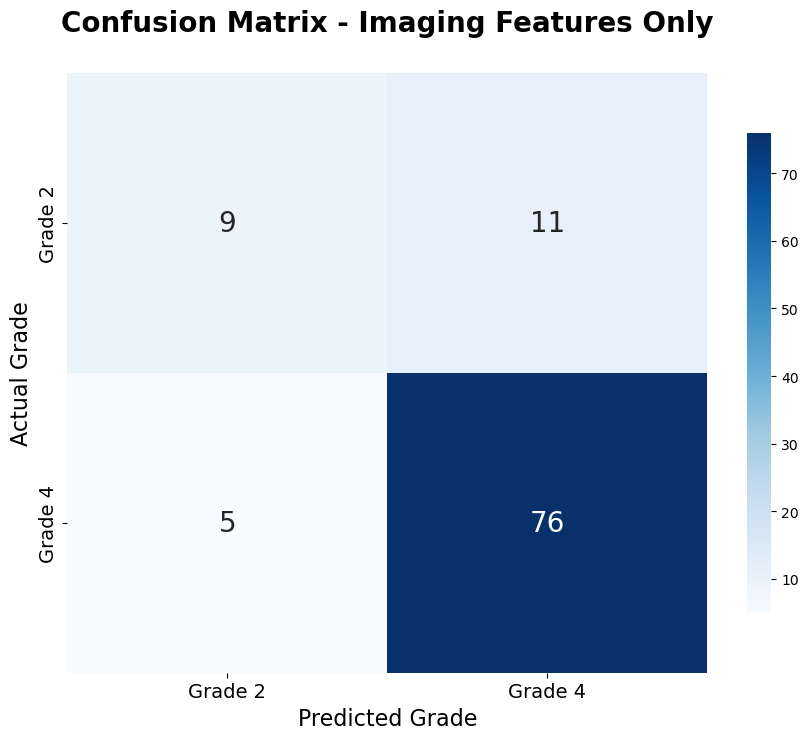

   ✓ Confusion matrix saved as 'PDGM/confusion_matrix_imaging.png'


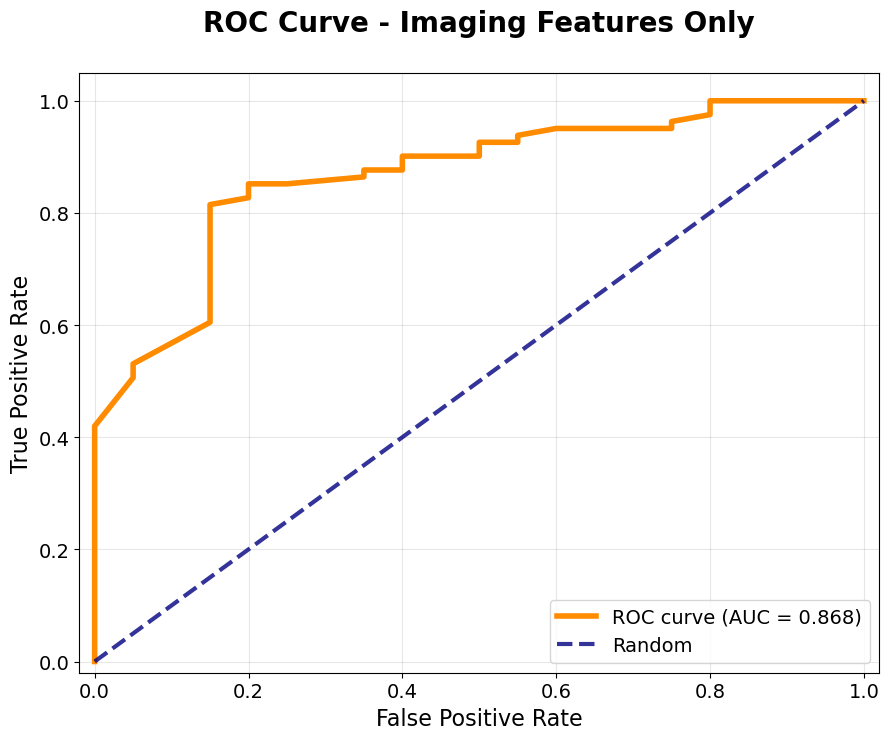

   ✓ ROC curve saved as 'PDGM/roc_curve_imaging.png'


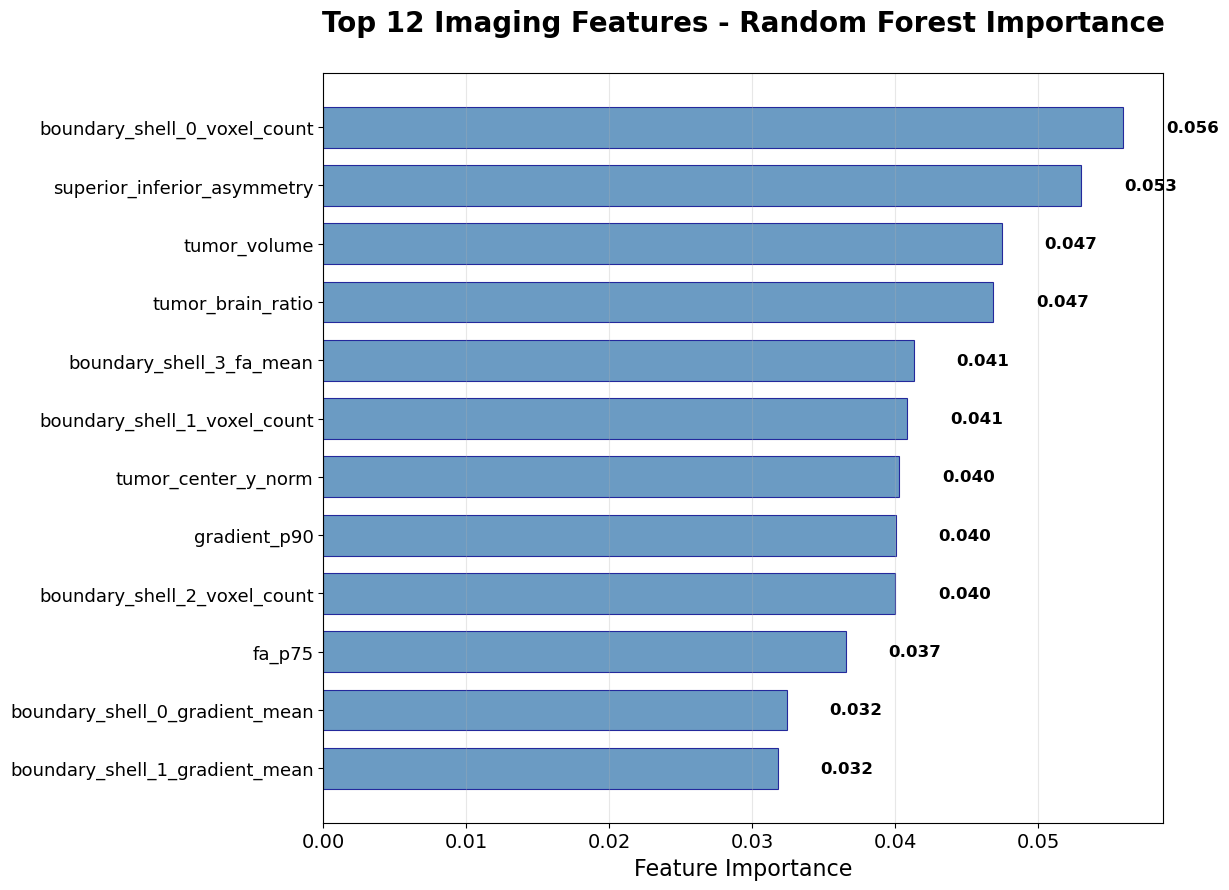

   ✓ Feature importance plot saved as 'PDGM/feature_importance_imaging.png'

   ✓ All individual plots created and saved for PowerPoint use

FEATURE IMPORTANCE ANALYSIS

ALL IMAGING FEATURES RANKED BY IMPORTANCE:
Rank Feature                                              Importance  Cumulative%
--------------------------------------------------------------------------------
   1. boundary_shell_0_voxel_count                    :   0.055972 (   5.6%)
   2. superior_inferior_asymmetry                     :   0.053014 (  10.9%)
   3. tumor_volume                                    :   0.047463 (  15.6%)
   4. tumor_brain_ratio                               :   0.046884 (  20.3%)
   5. boundary_shell_3_fa_mean                        :   0.041313 (  24.5%)
   6. boundary_shell_1_voxel_count                    :   0.040852 (  28.5%)
   7. tumor_center_y_norm                             :   0.040310 (  32.6%)
   8. gradient_p90                                    :   0.040055 (  36.6%)
   9. bo

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           balanced_accuracy_score, roc_curve, auc)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

def run_imaging_only_pipeline():
    """
    Run Random Forest pipeline using only imaging features from the updated metadata files
    """
    print("="*60)
    print("IMAGING-ONLY RANDOM FOREST PIPELINE")
    print("="*60)
    
    # Load the updated metadata files with imaging features
    print("\n1. Loading updated metadata with imaging features...")
    df_train = pd.read_csv('PDGM/train_metadata_with_imaging.csv')
    df_test = pd.read_csv('PDGM/test_metadata_with_imaging.csv')
    
    print(f"   Train data shape: {df_train.shape}")
    print(f"   Test data shape: {df_test.shape}")
    
    # Identify and filter only imaging features
    print("\n2. Filtering imaging features...")
    
    # Columns to exclude (non-imaging features)
    exclude_cols = ['ID', 'WHO CNS Grade']
    
    # Clinical/molecular feature patterns to exclude - MGMT is molecular/clinical!
    clinical_patterns = ['Sex_', 'MGMT', 'mgmt', 'IDH_', 'idh', '1p/19q_', '1p19q', 'Age', 'age']
    
    # Also check for any original clinical columns that might still be present
    clinical_exact_matches = ['MGMT status', 'MGMT index', 'mgmt_status', 'mgmt_index', 
                             'Sex', 'sex', 'IDH', 'idh', 'IDH_status', 'idh_status',
                             '1p/19q', '1p19q', 'Age at MRI', 'age_at_mri', 
                             'EOR', 'eor', 'overall_survival_days']
    
    # Get all column names
    all_cols = df_train.columns.tolist()
    
    # Find clinical columns to exclude (pattern-based)
    clinical_cols = []
    for col in all_cols:
        if any(pattern in col for pattern in clinical_patterns):
            clinical_cols.append(col)
    
    # Find clinical columns to exclude (exact matches)
    clinical_exact = [col for col in all_cols if col in clinical_exact_matches]
    
    # Combine all exclusions
    all_clinical = list(set(clinical_cols + clinical_exact))
    final_exclude = exclude_cols + all_clinical
    
    # Keep only imaging features
    imaging_cols_all = [col for col in all_cols if col not in final_exclude]
    
    # Drop redundant/noisy imaging features for cleaner analysis
    redundant_features = [
        'fa_min', 'fa_max', 'fa_median', 'fa_mode',  # redundant with other stats
        'fa_p5', 'fa_p95', 'fa_p10', 'fa_p90',      # extreme percentiles, noisy
        'fa_std', 'gradient_std', 'hemispheric_asymmetry_std',  # all std features - noisy
        'gradient_median',                           # redundant with gradient_mean
        'superior_fa_mean', 'inferior_fa_mean',      # keep asymmetry ratio instead
        'left_hemisphere_fa_mean', 'right_hemisphere_fa_mean',  # keep asymmetry instead
        # Shell features to exclude
        'shell_0_fa_mean', 'shell_0_fa_std', 'shell_0_fa_median', 'shell_0_voxel_count',
        'shell_1_fa_mean', 'shell_1_fa_std', 'shell_1_fa_median', 'shell_1_voxel_count',
        'shell_2_fa_mean', 'shell_2_fa_std', 'shell_2_fa_median', 'shell_2_voxel_count',
        'shell_3_fa_mean', 'shell_3_fa_std', 'shell_3_fa_median', 'shell_3_voxel_count',
        'shell_0_gradient_mean', 'shell_0_gradient_std',
        'shell_1_gradient_mean', 'shell_1_gradient_std',
        'shell_2_gradient_mean', 'shell_2_gradient_std',
        'shell_3_gradient_mean', 'shell_3_gradient_std'
    ]
    
    # Also remove any other shell-based std features dynamically
    shell_std_features = [col for col in imaging_cols_all if 'shell' in col and '_std' in col and col not in redundant_features]
    redundant_features.extend(shell_std_features)
    
    # Filter out redundant features
    imaging_cols = [col for col in imaging_cols_all if col not in redundant_features]
    
    print(f"   Imaging features before filtering: {len(imaging_cols_all)}")
    print(f"   Redundant features removed: {len(redundant_features)}")
    print(f"   Final imaging features: {len(imaging_cols)}")
    
    # Show which redundant features were actually present and removed
    actually_removed = [col for col in redundant_features if col in imaging_cols_all]
    if actually_removed:
        print(f"   Actually removed: {actually_removed}")
    else:
        print(f"   Note: None of the redundant features were present in dataset")
    
    print(f"   Total columns: {len(all_cols)}")
    print(f"   Excluded columns: {len(final_exclude)}")
    print(f"   Imaging features: {len(imaging_cols)}")
    
    # Print detailed breakdown of features
    print(f"\n" + "="*50)
    print("FEATURE CATEGORIZATION")
    print("="*50)
    
    print(f"\nESSENTIAL COLUMNS (excluded):")
    for col in exclude_cols:
        if col in all_cols:
            print(f"   {col}")
    
    print(f"\nCLINICAL/MOLECULAR FEATURES (excluded):")
    clinical_sorted = sorted(all_clinical)
    for col in clinical_sorted:
        print(f"   {col}")
    
    print(f"\nIMAGING FEATURES (included - showing first 20):")
    imaging_sorted = sorted(imaging_cols)
    for i, col in enumerate(imaging_sorted[:20]):
        print(f"   {col}")
    if len(imaging_cols) > 20:
        print(f"   ... and {len(imaging_cols) - 20} more imaging features")
    
    print(f"\nFEATURE SUMMARY:")
    print(f"   Clinical/molecular features excluded: {len(all_clinical)}")
    print(f"   Imaging features included: {len(imaging_cols)}")
    print(f"   Essential columns excluded: {len([c for c in exclude_cols if c in all_cols])}")
    print(f"   Total columns in dataset: {len(all_cols)}")
    
    # Save feature lists for reference
    feature_breakdown = {
        'clinical_molecular_features': clinical_sorted,
        'imaging_features': imaging_sorted,
        'excluded_essential': [c for c in exclude_cols if c in all_cols],
        'total_columns': len(all_cols)
    }
    
    import json
    with open('PDGM/feature_breakdown.json', 'w') as f:
        json.dump(feature_breakdown, f, indent=2)
    print(f"   ✓ Feature breakdown saved to 'PDGM/feature_breakdown.json'")
    
    # Prepare features and targets
    print("\n3. Preparing features and targets...")
    X_train = df_train[imaging_cols].copy()
    X_test = df_test[imaging_cols].copy()
    y_train = df_train['WHO CNS Grade'].copy()
    y_test = df_test['WHO CNS Grade'].copy()
    
    print(f"   X_train shape: {X_train.shape}")
    print(f"   X_test shape: {X_test.shape}")
    print(f"   y_train shape: {y_train.shape}")
    print(f"   y_test shape: {y_test.shape}")
    
    # Check for any remaining missing values
    train_missing = X_train.isna().sum().sum()
    test_missing = X_test.isna().sum().sum()
    
    if train_missing > 0 or test_missing > 0:
        print(f"   WARNING: Missing values - Train: {train_missing}, Test: {test_missing}")
        # Fill any remaining missing values
        X_train = X_train.fillna(X_train.median())
        X_test = X_test.fillna(X_train.median())  # Use train median for test
        print(f"   Missing values filled with median")
    
    # Check grade distribution
    print(f"\n4. Class distribution:")
    train_dist = y_train.value_counts().sort_index()
    test_dist = y_test.value_counts().sort_index()
    
    for grade in sorted(y_train.unique()):
        train_pct = (y_train == grade).mean() * 100
        test_pct = (y_test == grade).mean() * 100
        print(f"   Grade {grade} - Train: {train_pct:.1f}%, Test: {test_pct:.1f}%")
    
    # Analyze imaging features by grade (LOW vs HIGH grade)
    print(f"\n4.5 IMAGING FEATURES BY TUMOR GRADE")
    print("="*60)
    
    # Combine train and test for comprehensive analysis
    X_combined = pd.concat([X_train, X_test], axis=0)
    y_combined = pd.concat([y_train, y_test], axis=0)
    
    print(f"\nStatistical comparison between Low Grade (2) vs High Grade (4) tumors...")
    print(f"Total samples: Low Grade = {(y_combined == 2).sum()}, High Grade = {(y_combined == 4).sum()}")
    
    # Calculate median and IQR by grade
    feature_comparison = pd.DataFrame({
        'feature': imaging_cols,
        'low_grade_median': [X_combined[y_combined == 2][col].median() for col in imaging_cols],
        'low_grade_q25': [X_combined[y_combined == 2][col].quantile(0.25) for col in imaging_cols],
        'low_grade_q75': [X_combined[y_combined == 2][col].quantile(0.75) for col in imaging_cols],
        'high_grade_median': [X_combined[y_combined == 4][col].median() for col in imaging_cols],
        'high_grade_q25': [X_combined[y_combined == 4][col].quantile(0.25) for col in imaging_cols],
        'high_grade_q75': [X_combined[y_combined == 4][col].quantile(0.75) for col in imaging_cols],
    })
    
    # Calculate IQR
    feature_comparison['low_grade_iqr'] = feature_comparison['low_grade_q75'] - feature_comparison['low_grade_q25']
    feature_comparison['high_grade_iqr'] = feature_comparison['high_grade_q75'] - feature_comparison['high_grade_q25']
    
    # Mann-Whitney U test (non-parametric alternative to t-test)
    from scipy import stats
    
    p_values = []
    for col in imaging_cols:
        low_vals = X_combined[y_combined == 2][col].dropna()
        high_vals = X_combined[y_combined == 4][col].dropna()
        _, p_val = stats.mannwhitneyu(low_vals, high_vals, alternative='two-sided')
        p_values.append(p_val)
    
    feature_comparison['p_value'] = p_values
    feature_comparison['significant'] = feature_comparison['p_value'] < 0.05
    
    # Sort by p-value (most significant differences first)
    feature_comparison = feature_comparison.sort_values('p_value', ascending=True)
    
    print(f"\nIMAGING FEATURES RANKED BY STATISTICAL SIGNIFICANCE:")
    print(f"{'Feature':35} {'Low Grade Median':>15} {'Low IQR':>10} {'High Grade Median':>16} {'High IQR':>10} {'P-value':>10} {'Sig?':>5}")
    print("-" * 110)
    
    for i, (_, row) in enumerate(feature_comparison.head(20).iterrows()):
        sig_marker = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
        print(f"{row['feature']:35} {row['low_grade_median']:14.4f} {row['low_grade_iqr']:9.4f} {row['high_grade_median']:15.4f} {row['high_grade_iqr']:9.4f} {row['p_value']:9.6f} {sig_marker:>5}")
    
    print(f"\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")
    print(f"Test used: Mann-Whitney U (non-parametric)")
    print(f"IQR = Interquartile Range (Q75 - Q25)")
    
    # Summary statistics
    significant_features = feature_comparison['significant'].sum()
    highly_significant = (feature_comparison['p_value'] < 0.001).sum()
    
    print(f"\nSUMMARY:")
    print(f"  Highly significant features (p<0.001): {highly_significant}")
    print(f"  All significant features (p<0.05): {significant_features}/{len(imaging_cols)}")
    
    # Save detailed comparison
    feature_comparison.to_csv('PDGM/imaging_features_statistical_comparison.csv', index=False)
    print(f"  ✓ Statistical comparison saved to 'PDGM/imaging_features_statistical_comparison.csv'")
    
    # Compute class weights to address imbalance
    print("\n5. Computing class weights...")
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, weights))
    
    print(f"   Classes: {classes}")
    print(f"   Weights: {weights}")
    print(f"   Class weight dict: {class_weight_dict}")
    
    # Define the pipeline (scaling + random forest)
    print("\n6. Setting up pipeline...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(
            n_estimators=100,
            class_weight=class_weight_dict,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    print("   Pipeline components:")
    print("   - StandardScaler for feature normalization")
    print("   - RandomForestClassifier with balanced class weights")
    
    # Train model on training set only
    print("\n7. Training model on training set...")
    pipeline.fit(X_train, y_train)
    
    # Evaluate training performance (just for reference)
    print("\n8. Training set performance (for reference only)...")
    y_train_pred = pipeline.predict(X_train)
    train_accuracy = (y_train_pred == y_train).mean()
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
    
    print(f"   Training Accuracy: {train_accuracy:.4f}")
    print(f"   Training Balanced Accuracy: {train_balanced_accuracy:.4f}")
    print("   (Note: Training performance may be optimistic due to overfitting)")
    
    # Evaluate on held-out test set
    print("\n9. Test set evaluation (true performance)...")
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    
    # Calculate additional metrics
    test_accuracy = (y_pred == y_test).mean()
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    
    # For ROC-AUC, we need to handle multiclass
    unique_classes = sorted(y_test.unique())
    n_classes = len(unique_classes)
    
    if n_classes == 2:
        # Binary classification
        test_roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        print(f"   Test Accuracy: {test_accuracy:.4f}")
        print(f"   Test Balanced Accuracy: {test_balanced_accuracy:.4f}")
        print(f"   Test ROC-AUC: {test_roc_auc:.4f}")
        
        # Plot ROC curve for binary classification
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=unique_classes[1])
        
    else:
        # Multiclass classification
        test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
        print(f"   Test Accuracy: {test_accuracy:.4f}")
        print(f"   Test Balanced Accuracy: {test_balanced_accuracy:.4f}")
        print(f"   Test ROC-AUC (weighted): {test_roc_auc:.4f}")
        
        # For multiclass, we'll plot ROC curves for each class vs rest
        y_test_bin = label_binarize(y_test, classes=unique_classes)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i, class_label in enumerate(unique_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
    print("\n" + "="*60)
    print("DETAILED RESULTS")
    print("="*60)
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Print confusion matrix with labels for clarity
    unique_labels = sorted(y_test.unique())
    print(f"\nConfusion Matrix (rows=actual, cols=predicted):")
    print(f"{'':>8}", end="")
    for label in unique_labels:
        print(f"{f'Pred_{label}':>8}", end="")
    print()
    
    for i, actual_label in enumerate(unique_labels):
        print(f"True_{actual_label}:", end="")
        for j, pred_label in enumerate(unique_labels):
            print(f"{cm[i,j]:>8}", end="")
        print()
    
    # Feature importance analysis (MOVED BEFORE VISUALIZATIONS)
    print("\n" + "="*60)
    print("IMAGING FEATURE IMPORTANCE")
    print("="*60)
    
    # Get feature importance from the trained random forest
    rf_model = pipeline.named_steps['rf']
    feature_importance = rf_model.feature_importances_
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': imaging_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"\nALL IMAGING FEATURES RANKED BY IMPORTANCE:")
    print(f"{'Rank':>4} {'Feature':50} {'Importance':>12} {'Cumulative%':>12}")
    print("-" * 80)
    
    cumulative_importance = 0
    for i, (_, row) in enumerate(importance_df.iterrows()):
        cumulative_importance += row['importance']
        cumulative_pct = cumulative_importance / importance_df['importance'].sum() * 100
        print(f"{i+1:4d}. {row['feature']:48s}: {row['importance']:10.6f} ({cumulative_pct:6.1f}%)")
    
    # Summary statistics
    print(f"\nFeature Importance Summary:")
    print(f"   Total features: {len(importance_df)}")
    print(f"   Mean importance: {feature_importance.mean():.6f}")
    print(f"   Std importance: {feature_importance.std():.6f}")
    print(f"   Min importance: {feature_importance.min():.6f}")
    print(f"   Max importance: {feature_importance.max():.6f}")
    print(f"   Top 5 features account for: {importance_df.head(5)['importance'].sum():.1%} of total importance")
    print(f"   Top 10 features account for: {importance_df.head(10)['importance'].sum():.1%} of total importance")
    print(f"   Bottom 50% features account for: {importance_df.tail(len(importance_df)//2)['importance'].sum():.1%} of total importance")
    
    # Create visualizations (NOW AFTER importance_df IS CREATED)
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. CONFUSION MATRIX HEATMAP (Separate plot)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[f'Grade {i}' for i in unique_labels],
                yticklabels=[f'Grade {i}' for i in unique_labels],
                annot_kws={'size': 20}, cbar_kws={'shrink': 0.8})
    plt.title('Confusion Matrix - Imaging Features Only', fontsize=20, fontweight='bold', pad=30)
    plt.xlabel('Predicted Grade', fontsize=16)
    plt.ylabel('Actual Grade', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/confusion_matrix_imaging.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Confusion matrix saved as 'PDGM/confusion_matrix_imaging.png'")
    
    # 2. ROC CURVE (Separate plot)
    plt.figure(figsize=(10, 8))
    if n_classes == 2:
        # Binary ROC curve
        plt.plot(fpr, tpr, color='darkorange', lw=4, 
                label=f'ROC curve (AUC = {test_roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', alpha=0.8, label='Random')
        plt.xlim([-0.02, 1.02])
        plt.ylim([-0.02, 1.05])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC Curve - Imaging Features Only', fontsize=20, fontweight='bold', pad=30)
        plt.legend(loc="lower right", fontsize=14)
        plt.grid(True, alpha=0.3)
    else:
        # Multiclass ROC curves
        colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
        for i, (class_label, color) in enumerate(zip(unique_classes, colors)):
            plt.plot(fpr[i], tpr[i], color=color, lw=4,
                    label=f'Grade {class_label} (AUC = {roc_auc[i]:.3f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', alpha=0.8, label='Random')
        plt.xlim([-0.02, 1.02])
        plt.ylim([-0.02, 1.05])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC Curves - Imaging Features Only', fontsize=20, fontweight='bold', pad=30)
        plt.legend(loc="lower right", fontsize=13)
        plt.grid(True, alpha=0.3)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/roc_curve_imaging.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ ROC curve saved as 'PDGM/roc_curve_imaging.png'")
    
    # 3. FEATURE IMPORTANCE (Separate plot)
    plt.figure(figsize=(12, 10))
    top_features = importance_df.head(12)  # Show top 12 for better spacing
    bars = plt.barh(range(len(top_features)), top_features['importance'], 
                    color='steelblue', alpha=0.8, edgecolor='darkblue', linewidth=0.8, height=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=13)
    plt.xlabel('Feature Importance', fontsize=16)
    plt.title('Top 12 Imaging Features - Random Forest Importance', fontsize=20, fontweight='bold', pad=30)
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.003, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=12, fontweight='bold')
    
    plt.grid(axis='x', alpha=0.3)
    plt.xticks(fontsize=14)
    plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.15)
    plt.savefig('PDGM/feature_importance_imaging.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Feature importance plot saved as 'PDGM/feature_importance_imaging.png'")
    
    print("\n   ✓ All individual plots created and saved for PowerPoint use")

    
    # Feature importance analysis
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Get feature importance from the trained random forest
    rf_model = pipeline.named_steps['rf']
    feature_importance = rf_model.feature_importances_
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': imaging_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"\nALL IMAGING FEATURES RANKED BY IMPORTANCE:")
    print(f"{'Rank':>4} {'Feature':50} {'Importance':>12} {'Cumulative%':>12}")
    print("-" * 80)
    
    cumulative_importance = 0
    for i, (_, row) in enumerate(importance_df.iterrows()):
        cumulative_importance += row['importance']
        cumulative_pct = cumulative_importance / importance_df['importance'].sum() * 100
        print(f"{i+1:4d}. {row['feature']:48s}: {row['importance']:10.6f} ({cumulative_pct:6.1f}%)")
    
    # Summary statistics
    print(f"\nFeature Importance Summary:")
    print(f"   Total features: {len(importance_df)}")
    print(f"   Mean importance: {feature_importance.mean():.6f}")
    print(f"   Std importance: {feature_importance.std():.6f}")
    print(f"   Min importance: {feature_importance.min():.6f}")
    print(f"   Max importance: {feature_importance.max():.6f}")
    print(f"   Top 5 features account for: {importance_df.head(5)['importance'].sum():.1%} of total importance")
    print(f"   Top 10 features account for: {importance_df.head(10)['importance'].sum():.1%} of total importance")
    print(f"   Bottom 50% features account for: {importance_df.tail(len(importance_df)//2)['importance'].sum():.1%} of total importance")
    
    # Save results
    print("\n" + "="*60)
    print("SAVING RESULTS")
    print("="*60)
    
    # Save feature importance
    importance_df.to_csv('PDGM/imaging_feature_importance.csv', index=False)
    print("   ✓ Feature importance saved to 'PDGM/imaging_feature_importance.csv'")
    
    # Save predictions
    results_df = pd.DataFrame({
        'ID': df_test['ID'],
        'true_grade': y_test,
        'predicted_grade': y_pred,
        'prediction_probability': y_pred_proba.max(axis=1)
    })
    results_df.to_csv('PDGM/test_predictions.csv', index=False)
    print("   ✓ Test predictions saved to 'PDGM/test_predictions.csv'")
    
    # Save model performance summary
    performance_summary = {
        'train_accuracy': float(train_accuracy),
        'train_balanced_accuracy': float(train_balanced_accuracy),
        'test_accuracy': float(test_accuracy),
        'test_balanced_accuracy': float(test_balanced_accuracy),
        'test_roc_auc': float(test_roc_auc),
        'n_imaging_features': len(imaging_cols),
        'n_train_samples': len(X_train),
        'n_test_samples': len(X_test)
    }
    
    import json
    with open('PDGM/performance_summary.json', 'w') as f:
        json.dump(performance_summary, f, indent=2)
    print("   ✓ Performance summary saved to 'PDGM/performance_summary.json'")
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)
    print(f"Using {len(imaging_cols)} imaging features only")
    print(f"Training accuracy: {train_accuracy:.3f} (may be optimistic)")
    print(f"Test set accuracy: {test_accuracy:.3f} (true performance)")
    print(f"Test set balanced accuracy: {test_balanced_accuracy:.3f}")
    
    return pipeline, importance_df, performance_summary

if __name__ == "__main__":
    # Run the imaging-only pipeline
    model, feature_importance, performance = run_imaging_only_pipeline()